In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import Env, spaces
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
import os
import logging
import json
import torch
from torch.amp import autocast
from datetime import date

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Custom JSON encoder
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer, np.floating)):
            return int(obj) if isinstance(obj, np.integer) else float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, date):
            return str(obj)
        return super().default(obj)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# 1. Data Preprocessing
def preprocess_data(file_path, top_n_products=10, min_days=90, min_price_var=0.1, min_transactions=200):
    """Load and preprocess dataset, selecting top N products."""
    try:
        df = pd.read_csv(file_path, encoding='latin1')
        df = df.dropna(subset=['CustomerID', 'Description', 'InvoiceDate'])
        df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
        df['InvoiceNo'] = df['InvoiceNo'].astype(str)
        
        # Validate InvoiceNo format
        unique_prefixes = df['InvoiceNo'].str[0].unique()
        logger.info(f"InvoiceNo dtype: {df['InvoiceNo'].dtype}")
        logger.info(f"Sample InvoiceNo: {df['InvoiceNo'].unique()[:5].tolist()}")
        logger.info(f"Unique InvoiceNo prefixes: {unique_prefixes.tolist()}")
        logger.info(f"Cancellations before filtering: {(df['InvoiceNo'].str.startswith('C')).sum()}")
        df = df[~df['InvoiceNo'].str.startswith('C')]
        logger.info(f"Rows after removing cancellations: {len(df)}")
        
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        df['CustomerID'] = df['CustomerID'].astype(str)
        df['StockCode'] = df['StockCode'].astype(str)
        df['Date'] = df['InvoiceDate'].dt.date
        df['Month'] = df['InvoiceDate'].dt.month
        
        # Summary for specific products
        products_to_check = [
            'SPACEBOY BABY GIFT SET', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', '3 DRAWER ANTIQUE WHITE WOOD CABINET',
            '3 HEARTS HANGING DECORATION RUSTIC', '3 HOOK PHOTO SHELF ANTIQUE WHITE', '3 PIECE SPACEBOY COOKIE CUTTER SET',
            '3 RAFFIA RIBBONS 50\'S CHRISTMAS', '3 ROSE MORRIS BOXED CANDLES', '3 STRIPEY MICE FELTCRAFT',
            '3 TRADITIONAL BISCUIT CUTTERS  SET', '6 RIBBONS RUSTIC CHARM', 'AIRLINE BAG VINTAGE TOKYO 78',
            'ALARM CLOCK BAKELIKE CHOCOLATE', 'ALARM CLOCK BAKELIKE GREEN'
        ]
        summary = df[df['Description'].isin(products_to_check)].groupby('Description').agg({
            'Date': 'nunique',
            'UnitPrice': ['mean', 'var', 'min', 'max'],
            'Quantity': ['sum', 'mean', 'var', 'count']
        })
        summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
        logger.info(f"Dataset summary for requested products:\n{summary.to_string()}")
        
        for product in products_to_check:
            unique_prices = len(df[df['Description'] == product]['UnitPrice'].unique())
            logger.info(f"Unique prices for {product}: {unique_prices}")
        
        # Filter products
        product_counts = df.groupby('Description').agg({
            'Date': 'nunique',
            'UnitPrice': ['var', lambda x: len(np.unique(x))],
            'Quantity': 'count'
        })
        product_counts.columns = ['days', 'price_var', 'unique_prices', 'transactions']
        valid_products = product_counts[
            (product_counts['days'] >= min_days) &
            (product_counts['price_var'].fillna(0) >= min_price_var) &
            (product_counts['unique_prices'] >= 5) &
            (product_counts['transactions'] >= min_transactions)
        ]
        products = valid_products.index.tolist()[:top_n_products]
        
        logger.info(f"Found {len(valid_products)} products meeting criteria, selecting {len(products)}")
        if not products:
            raise ValueError("No products meet minimum data requirements")
        
        df = df[df['Description'].isin(products)]
        return df, products
    except Exception as e:
        logger.error(f"Preprocessing failed: {str(e)}")
        raise

# 2. Demand Model Estimation
def estimate_demand_model(df, product):
    """Fit a log-linear demand model with polynomial features and robust fallback."""
    try:
        df_product = df[df['Description'] == product].copy()
        daily_data = df_product.groupby('Date').agg({
            'Quantity': 'sum',
            'UnitPrice': 'mean',
            'Month': 'first'
        }).rename(columns={'Quantity': 'DailyDemand', 'UnitPrice': 'AvgPrice'})
        daily_data['Revenue'] = daily_data['DailyDemand'] * daily_data['AvgPrice']
        
        # Data augmentation for sparse prices
        unique_prices = len(daily_data['AvgPrice'].unique())
        logger.info(f"Unique prices for {product}: {unique_prices}, Sample: {daily_data['AvgPrice'].unique()[:5].tolist()}")
        logger.info(f"Data points for {product}: {len(daily_data)}")
        if unique_prices < 5:
            logger.warning(f"Augmenting prices for {product}")
            daily_data['AvgPrice'] = daily_data['AvgPrice'].interpolate(method='linear', limit_direction='both')
            unique_prices = len(daily_data['AvgPrice'].unique())
        
        if len(daily_data) < 30:
            raise ValueError(f"Insufficient days: {len(daily_data)}")
        if unique_prices < 5:
            raise ValueError(f"Insufficient unique prices after augmentation: {unique_prices}")
        if daily_data['DailyDemand'].sum() < 300:
            raise ValueError(f"Insufficient total demand: {daily_data['DailyDemand'].sum()}")
        
        daily_data['DailyDemand'] = daily_data['DailyDemand'].clip(lower=1, upper=50)
        daily_data['AvgPrice'] = daily_data['AvgPrice'].clip(lower=0.1, upper=20)
        
        daily_data['LogDemand'] = np.log(daily_data['DailyDemand'] + 1)
        daily_data['LogPrice'] = np.log(daily_data['AvgPrice'] + 1)
        daily_data['LogPrice2'] = daily_data['LogPrice'] ** 2  # Polynomial feature
        
        # Try OLS with polynomial features
        model = smf.ols('LogDemand ~ LogPrice + LogPrice2', data=daily_data).fit()
        intercept, slope, slope2 = model.params['Intercept'], model.params['LogPrice'], model.params['LogPrice2']
        
        if np.isnan(intercept) or np.isnan(slope) or np.isnan(slope2) or abs(slope) > 10 or model.rsquared < 0.1:
            logger.warning(f"Unstable OLS model for {product} (R²={model.rsquared:.2f}, intercept={intercept:.2f}, slope={slope:.2f})")
            # Fallback to Ridge regression
            ridge = Ridge(alpha=1.0)
            X = daily_data[['LogPrice', 'LogPrice2']].values
            y = daily_data['LogDemand'].values
            ridge.fit(X, y)
            intercept, slope, slope2 = ridge.intercept_, ridge.coef_[0], ridge.coef_[1]
            logger.info(f"Ridge fallback for {product}: intercept={intercept:.2f}, slope={slope:.2f}, slope2={slope2:.2f}")
        
        # Clip extreme coefficients
        slope = np.clip(slope, -10, 10)
        slope2 = np.clip(slope2, -5, 5)
        
        logger.info(f"Demand model for {product}: intercept={intercept:.2f}, slope={slope:.2f}, slope2={slope2:.2f}, R²={model.rsquared:.2f}")
        
        daily_data['LagDemand'] = daily_data['DailyDemand'].shift(1).fillna(daily_data['DailyDemand'].mean())
        daily_data['LagPrice'] = daily_data['AvgPrice'].shift(1).fillna(daily_data['AvgPrice'].mean())
        daily_data['RollingDemand7'] = daily_data['DailyDemand'].rolling(window=7, min_periods=1).mean()
        daily_data['PriceElasticity'] = -slope * (daily_data['DailyDemand'] / (daily_data['AvgPrice'] + 0.01))
        
        daily_data['PriceElasticity'] = daily_data['PriceElasticity'].clip(lower=-1.5, upper=1.5)
        daily_data['LagDemand'] = daily_data['LagDemand'].clip(lower=0, upper=50)
        daily_data['LagPrice'] = daily_data['LagPrice'].clip(lower=0.1, upper=20)
        daily_data['RollingDemand7'] = daily_data['RollingDemand7'].clip(lower=0, upper=50)
        
        daily_data.dropna(inplace=True)
        daily_data.reset_index(inplace=True)
        
        if len(daily_data) < 30:
            raise ValueError(f"Insufficient data after preprocessing: {len(daily_data)} days")
        
        elasticity_stats = {
            'mean': float(daily_data['PriceElasticity'].mean()),
            'var': float(daily_data['PriceElasticity'].var()),
            'unique': int(len(daily_data['PriceElasticity'].unique())),
            'min': float(daily_data['PriceElasticity'].min()),
            'max': float(daily_data['PriceElasticity'].max())
        }
        logger.info(f"PriceElasticity stats for {product}: {json.dumps(elasticity_stats, cls=CustomEncoder)}")
        
        demand_model_info = {
            'product': product,
            'intercept': float(intercept),
            'slope': float(slope),
            'slope2': float(slope2),
            'rsquared': float(model.rsquared),
            'unique_prices': unique_prices,
            'data_points': len(daily_data)
        }
        with open(f"results/demand_models.json", "a") as f:
            json.dump(demand_model_info, f, cls=CustomEncoder)
            f.write("\n")
        
        return daily_data, intercept, slope, slope2
    except Exception as e:
        logger.error(f"Demand model failed for {product}: {str(e)}")
        raise

# 3. Custom Gym Environment
class DynamicPricingEnv(Env):
    """Gym environment for dynamic pricing with GPU support."""
    def __init__(self, data, state_features, intercept, slope, slope2, n_features=4):
        super().__init__()
        self.data = data
        self.state_features = torch.tensor(state_features, dtype=torch.float32, device=device)
        self.intercept = torch.tensor(intercept, dtype=torch.float32, device=device)
        self.slope = torch.tensor(slope, dtype=torch.float32, device=device)
        self.slope2 = torch.tensor(slope2, dtype=torch.float32, device=device)
        self.current_step = 0
        self.n_features = n_features
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_features,), dtype=np.float32)
        self.max_price = min(self.data['AvgPrice'].max() * 1.1, 20)
        self.min_price = max(0.1, self.data['AvgPrice'].min() * 0.9)
        self.max_price_change = 0.1
        self.avg_prices = torch.tensor(self.data['AvgPrice'].values, dtype=torch.float32, device=device)

    def reset(self, seed=None, options=None):
        self.current_step = 0
        obs = self.state_features[self.current_step].cpu().numpy()
        if np.any(np.isnan(obs)) or obs.shape[0] != self.n_features:
            logger.error(f"Invalid reset state: shape={obs.shape}, NaN={np.any(np.isnan(obs))}")
            obs = np.zeros(self.n_features, dtype=np.float32)
        return obs, {}

    def step(self, action):
        with autocast('cuda'):
            action = torch.tensor(action, dtype=torch.float32, device=device)
            price_change = torch.clamp(action, -1, 1) * self.max_price_change
            base_price = self.avg_prices[self.current_step]
            new_price = torch.clamp(base_price + price_change, self.min_price, self.max_price)
            
            log_new_price = torch.log(new_price + 1)
            log_new_demand = self.intercept - self.slope * log_new_price - self.slope2 * (log_new_price ** 2)
            log_new_demand += torch.normal(mean=0, std=0.05, size=(1,), device=device)
            new_demand = torch.clamp(torch.exp(log_new_demand) - 1, 1, 50).int()
            
            revenue = torch.max(torch.tensor(0, device=device), new_price * new_demand)
            reward = revenue / 100 - 0.01 * torch.abs(price_change)  # Penalize large price changes
            
            if torch.isnan(reward) or torch.isinf(reward):
                logger.error(f"Invalid reward: revenue={revenue.item()}")
                reward = torch.tensor(0, device=device)
            
            self.current_step += 1
            done = self.current_step >= len(self.data) - 1
            next_state = (
                self.state_features[self.current_step].cpu().numpy()
                if not done else np.zeros(self.n_features, dtype=np.float32)
            )
            if np.any(np.isnan(next_state)):
                logger.error("NaN in next state")
                next_state = np.zeros(self.n_features, dtype=np.float32)
            
            return next_state, reward.cpu().item(), done, False, {
                "new_price": new_price.cpu().item(),
                "new_demand": new_demand.cpu().item()
            }

    def render(self):
        pass

# 4. Rule-Based Pricing
def rule_based_pricing(daily_data, intercept, slope, slope2):
    """Apply 5% markup pricing."""
    try:
        avg_price = daily_data['AvgPrice'].mean()
        markup_price = np.clip(avg_price * 1.05, daily_data['AvgPrice'].min() * 0.9, daily_data['AvgPrice'].max() * 1.1)
        demands = [int(np.clip(np.exp(intercept - slope * np.log(markup_price + 1) - slope2 * (np.log(markup_price + 1) ** 2)) - 1, 1, 50)) 
                   for _ in range(len(daily_data) - 1)]
        return [max(0, markup_price * d) for d in demands]
    except Exception as e:
        logger.error(f"Rule-based pricing failed: {str(e)}")
        return [0] * (len(daily_data) - 1)

# 5. Train and Evaluate
def train_and_evaluate(df, products, output_dir="results"):
    """Train PPO and evaluate against baselines."""
    os.makedirs(output_dir, exist_ok=True)
    results = {}
    
    for product in products:
        logger.info(f"\nProcessing: {product}")
        try:
            daily_data, intercept, slope, slope2 = estimate_demand_model(df, product)
            scaler = MinMaxScaler()
            state_features = scaler.fit_transform(daily_data[['LagDemand', 'LagPrice', 'RollingDemand7', 'PriceElasticity']])
            
            if np.any(np.isnan(state_features)):
                logger.error(f"NaN in state features for {product}")
                continue
            
            env = DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2)
            check_env(env)
            
            # Wrap evaluation environment with Monitor
            eval_env = Monitor(DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2))
            eval_callback = EvalCallback(
                eval_env, best_model_save_path=f"{output_dir}/{product}_best_model",
                log_path=output_dir, eval_freq=10000, n_eval_episodes=5,
                deterministic=True, render=False,
                callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
            )
            
            model = PPO(
                "MlpPolicy", env, learning_rate=0.0005, n_steps=2048, batch_size=256,
                n_epochs=10, gamma=0.99, clip_range=0.2, verbose=0, device=device
            )
            with autocast('cuda'):
                model.learn(total_timesteps=500000, callback=eval_callback)
            
            obs, _ = env.reset()
            rewards, actions, prices, demands = [], [], [], []
            
            for _ in range(len(daily_data) - 1):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, _, info = env.step(action)
                rewards.append(reward * 100)
                actions.append(action.item())  # Fix NumPy deprecation
                prices.append(float(info['new_price']))
                demands.append(float(info['new_demand']))
                if done:
                    break
            
            rule_revenues = rule_based_pricing(daily_data, intercept, slope, slope2)
            
            original_revenue = float(daily_data['Revenue'].iloc[1:].sum())
            rl_revenue = float(max(100, sum(rewards)))
            rule_revenue = float(max(100, sum(rule_revenues)))
            improvement_rl = float((rl_revenue - original_revenue) / original_revenue * 100 if original_revenue > 0 else 0)
            improvement_rule = float((rule_revenue - original_revenue) / original_revenue * 100 if original_revenue > 0 else 0)
            
            t_stat_rl, p_value_rl = ttest_rel(daily_data['Revenue'].iloc[1:], rewards) if len(rewards) == len(daily_data['Revenue'].iloc[1:]) else (0, 1)
            t_stat_rule, p_value_rule = ttest_rel(daily_data['Revenue'].iloc[1:], rule_revenues) if len(rule_revenues) == len(daily_data['Revenue'].iloc[1:]) else (0, 1)
            
            cost_per_unit = 0.2
            original_profit = float((daily_data['Revenue'].iloc[1:] - daily_data['DailyDemand'].iloc[1:] * cost_per_unit).sum())
            rl_profit = float(sum([r - d * cost_per_unit for r, d in zip(rewards, demands)]))
            original_margin = float(original_profit / original_revenue * 100 if original_revenue > 0 else 0)
            rl_margin = float(rl_profit / rl_revenue * 100 if rl_revenue > 0 else 0)
            
            results[str(product)] = {
                'daily_data': daily_data.drop(columns=['Date']).to_dict(orient='records'),
                'rewards': [float(r) for r in rewards],
                'actions': actions,
                'prices': prices,
                'demands': demands,
                'rule_revenues': [float(r) for r in rule_revenues],
                'metrics': {
                    'original_revenue': original_revenue,
                    'rl_revenue': rl_revenue,
                    'rule_revenue': rule_revenue,
                    'improvement_rl': improvement_rl,
                    'p_value_rl': float(p_value_rl),
                    'improvement_rule': improvement_rule,
                    'p_value_rule': float(p_value_rule),
                    'original_profit': original_profit,
                    'rl_profit': rl_profit,
                    'original_margin': original_margin,
                    'rl_margin': rl_margin
                }
            }
            
            logger.info(f"Original Revenue: ₹{original_revenue:,.2f}")
            logger.info(f"RL Revenue: ₹{rl_revenue:,.2f} (Improvement: {improvement_rl:.2f}%, p-value: {p_value_rl:.4f})")
            logger.info(f"Rule-Based Revenue: ₹{rule_revenue:,.2f} (Improvement: {improvement_rule:.2f}%, p-value: {p_value_rule:.4f})")
            logger.info(f"Profit Margin: Original = ₹{original_profit:,.2f} ({original_margin:.2f}%), RL = ₹{rl_profit:,.2f} ({rl_margin:.2f}%)")
            
            price_std = float(np.std(prices))
            price_change_magnitude = float(np.mean(np.abs(np.diff(prices))))
            logger.info(f"Price Stability: Std Dev = ₹{price_std:.2f}, Avg Change = ₹{price_change_magnitude:.2f}")
            
            higher_demand_days = sum(d > od for d, od in zip(demands, daily_data['DailyDemand'].iloc[1:]))
            demand_retention = float(higher_demand_days / len(demands) * 100 if len(demands) > 0 else 0)
            logger.info(f"Demand Retention: {demand_retention:.2f}% days with higher RL demand")
            
            if daily_data['PriceElasticity'].iloc[1:].var() > 0.03 and len(daily_data['PriceElasticity'].iloc[1:].unique()) >= 3:
                try:
                    n_bins = min(3, len(daily_data['PriceElasticity'].iloc[1:].unique()) - 1)
                    elasticity_bins = pd.qcut(daily_data['PriceElasticity'].iloc[1:], q=n_bins, labels=[f'Bin_{i+1}' for i in range(n_bins)], duplicates='drop')
                    elasticity_analysis = {f'Bin_{i+1}': [] for i in range(n_bins)}
                    for e, r in zip(elasticity_bins, rewards):
                        elasticity_analysis[e].append(float(r))
                    for bin in elasticity_analysis:
                        avg_rev = float(np.mean(elasticity_analysis[bin]) if elasticity_analysis[bin] else 0)
                        logger.info(f"{bin} Elasticity Revenue: ₹{avg_rev:.2f}")
                except ValueError as e:
                    logger.warning(f"Elasticity binning failed for {product}: {str(e)}")
                    logger.info(f"Fallback Elasticity Revenue: ₹{float(np.mean(rewards)):.2f}")
            else:
                logger.info(f"Low elasticity variance for {product}. Fallback Revenue: ₹{float(np.mean(rewards)):.2f}")
            
            plt.figure(figsize=(12, 6))
            plt.plot(daily_data.index[1:], daily_data['AvgPrice'].iloc[1:], label='Original Price', linewidth=2)
            plt.plot(daily_data.index[1:], prices, label='RL Price', linestyle='--', linewidth=2)
            plt.plot(daily_data.index[1:], daily_data['DailyDemand'].iloc[1:], label='Demand', linewidth=2)
            plt.plot(daily_data.index[1:], daily_data['Revenue'].iloc[1:], label='Original Revenue', linewidth=2)
            plt.plot(daily_data.index[1:], rewards, label='RL Revenue', linestyle='--', linewidth=2)
            plt.plot(daily_data.index[1:], rule_revenues, label='Rule-Based Revenue', linestyle='-.', linewidth=2)
            plt.legend()
            plt.title(f"Dynamic Pricing: {product}")
            plt.xlabel("Index")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f"{output_dir}/{product}_pricing.png")
            plt.close()
            
            plt.figure(figsize=(8, 5))
            plt.hist([a * 0.1 for a in actions], bins=20, color='skyblue', edgecolor='black')
            plt.title(f"Price Adjustment Distribution: {product}")
            plt.xlabel("Price Adjustment (₹)")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.savefig(f"{output_dir}/{product}_adjustments.png")
            plt.close()
            
            plt.figure(figsize=(8, 5))
            plt.scatter(prices, demands, color='red', alpha=0.6)
            plt.title(f"RL Price vs. Demand: {product}")
            plt.xlabel("Price (₹)")
            plt.ylabel("Demand (Units)")
            plt.grid(True)
            plt.savefig(f"{output_dir}/{product}_price_demand.png")
            plt.close()
            
            plt.figure(figsize=(12, 6))
            plt.plot(daily_data.index[1:], np.cumsum(daily_data['Revenue'].iloc[1:]), label='Original Cumulative Revenue', linewidth=2)
            plt.plot(daily_data.index[1:], np.cumsum(rewards), label='RL Cumulative Revenue', linestyle='--', linewidth=2)
            plt.plot(daily_data.index[1:], np.cumsum(rule_revenues), label='Rule-Based Cumulative Revenue', linestyle='-.', linewidth=2)
            plt.legend()
            plt.title(f"Cumulative Revenue: {product}")
            plt.xlabel("Index")
            plt.ylabel("Cumulative Revenue (₹)")
            plt.grid(True)
            plt.savefig(f"{output_dir}/{product}_cumulative.png")
            plt.close()
            
            plt.figure(figsize=(8, 5))
            plt.scatter(daily_data['PriceElasticity'].iloc[1:], rewards, color='purple', alpha=0.6)
            plt.title(f"Price Elasticity vs. RL Revenue: {product}")
            plt.xlabel("Price Elasticity")
            plt.ylabel("RL Revenue (₹)")
            plt.grid(True)
            plt.savefig(f"{output_dir}/{product}_elasticity.png")
            plt.close()
        
        except Exception as e:
            logger.error(f"Error processing {product}: {str(e)}")
            try:
                daily_data = df[df['Description'] == product].groupby('Date').agg({
                    'Quantity': 'sum',
                    'UnitPrice': 'mean',
                    'Month': 'first'
                }).rename(columns={'Quantity': 'DailyDemand', 'UnitPrice': 'AvgPrice'})
                daily_data['Revenue'] = daily_data['DailyDemand'] * daily_data['AvgPrice']
                rule_revenues = rule_based_pricing(daily_data, 0, 0, 0)
                results[str(product)] = {
                    'daily_data': daily_data.drop(columns=['Date']).to_dict(orient='records'),
                    'rewards': [],
                    'actions': [],
                    'prices': [],
                    'demands': [],
                    'rule_revenues': [float(r) for r in rule_revenues],
                    'metrics': {
                        'original_revenue': float(daily_data['Revenue'].iloc[1:].sum()),
                        'rl_revenue': 0.0,
                        'rule_revenue': float(max(100, sum(rule_revenues))),
                        'improvement_rl': 0.0,
                        'p_value_rl': 1.0,
                        'improvement_rule': float((sum(rule_revenues) - daily_data['Revenue'].iloc[1:].sum()) / daily_data['Revenue'].iloc[1:].sum() * 100 if daily_data['Revenue'].iloc[1:].sum() > 0 else 0),
                        'p_value_rule': 1.0,
                        'original_profit': float((daily_data['Revenue'].iloc[1:] - daily_data['DailyDemand'].iloc[1:] * 0.2).sum()),
                        'rl_profit': 0.0,
                        'original_margin': float((daily_data['Revenue'].iloc[1:] - daily_data['DailyDemand'].iloc[1:] * 0.2).sum() / daily_data['Revenue'].iloc[1:].sum() * 100 if daily_data['Revenue'].iloc[1:].sum() > 0 else 0),
                        'rl_margin': 0.0
                    }
                }
                logger.info(f"Fallback to rule-based pricing for {product}")
            except Exception as fallback_e:
                logger.error(f"Fallback failed for {product}: {str(fallback_e)}")
            continue
    
    return results

# 6. Ablation Study
def ablation_study(df, product, output_dir="results"):
    """Evaluate feature importance."""
    try:
        daily_data, intercept, slope, slope2 = estimate_demand_model(df, product)
        features = ['LagDemand', 'LagPrice', 'RollingDemand7', 'PriceElasticity']
        ablation_results = {}
        
        for exclude_feature in features:
            logger.info(f"Ablation: Excluding {exclude_feature} for {product}")
            subset_features = [f for f in features if f != exclude_feature]
            scaler = MinMaxScaler()
            state_features = scaler.fit_transform(daily_data[subset_features])
            
            if np.any(np.isnan(state_features)):
                logger.error(f"NaN in ablation state features")
                continue
            
            env = DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2, n_features=len(subset_features))
            check_env(env)
            
            eval_env = Monitor(DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2, n_features=len(subset_features)))
            eval_callback = EvalCallback(
                eval_env, best_model_save_path=f"{output_dir}/{product}_ablation_{exclude_feature}_best_model",
                log_path=output_dir, eval_freq=10000, n_eval_episodes=5,
                deterministic=True, render=False,
                callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
            )
            
            model = PPO("MlpPolicy", env, learning_rate=0.0005, n_steps=2048, batch_size=256, n_epochs=10, gamma=0.99, clip_range=0.2, verbose=0, device=device)
            with autocast('cuda'):
                model.learn(total_timesteps=500000, callback=eval_callback)
            
            obs, _ = env.reset()
            rewards = []
            for _ in range(len(daily_data) - 1):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, _, _ = env.step(action)
                rewards.append(reward * 100)
                if done:
                    break
            
            ablation_results[exclude_feature] = float(max(0, sum(rewards)))
            logger.info(f"Revenue without {exclude_feature}: ₹{sum(rewards):,.2f}")
        
        plt.figure(figsize=(8, 5))
        plt.bar(ablation_results.keys(), ablation_results.values(), color='coral')
        plt.title(f"Ablation Study: {product}")
        plt.xlabel("Excluded Feature")
        plt.ylabel("RL Revenue (₹)")
        plt.grid(True)
        plt.savefig(f"{output_dir}/{product}_ablation.png")
        plt.close()
        
        return ablation_results
    except Exception as e:
        logger.error(f"Ablation study failed for {product}: {str(e)}")
        return {}

# 7. Robustness Test
def robustness_test(df, product, output_dir="results"):
    """Test robustness to demand noise."""
    try:
        noise_levels = [0.1, 0.2, 0.3]
        daily_data, intercept, slope, slope2 = estimate_demand_model(df, product)
        scaler = MinMaxScaler()
        state_features = scaler.fit_transform(daily_data[['LagDemand', 'LagPrice', 'RollingDemand7', 'PriceElasticity']])
        robustness_results = {}
        
        for noise in noise_levels:
            logger.info(f"Robustness test: Noise {noise} for {product}")
            env = DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2)
            def custom_step(self, action):
                with autocast('cuda'):
                    action = torch.tensor(action, dtype=torch.float32, device=device)
                    price_change = torch.clamp(action, -1, 1) * self.max_price_change
                    base_price = self.avg_prices[self.current_step]
                    new_price = torch.clamp(base_price + price_change, self.min_price, self.max_price)
                    log_new_price = torch.log(new_price + 1)
                    log_new_demand = self.intercept - self.slope * log_new_price - self.slope2 * (log_new_price ** 2)
                    log_new_demand += torch.normal(mean=0, std=noise, size=(1,), device=device)
                    new_demand = torch.clamp(torch.exp(log_new_demand) - 1, 1, 50).int()
                    revenue = torch.max(torch.tensor(0, device=device), new_price * new_demand)
                    reward = revenue / 100 - 0.01 * torch.abs(price_change)
                    if torch.isnan(reward) or torch.isinf(reward):
                        reward = torch.tensor(0, device=device)
                    self.current_step += 1
                    done = self.current_step >= len(self.data) - 1
                    next_state = (
                        self.state_features[self.current_step].cpu().numpy()
                        if not done else np.zeros(self.n_features, dtype=np.float32)
                    )
                    return next_state, reward.cpu().item(), done, False, {
                        "new_price": new_price.cpu().item(),
                        "new_demand": new_demand.cpu().item()
                    }
            
            env.step = custom_step.__get__(env, DynamicPricingEnv)
            check_env(env)
            
            eval_env = Monitor(DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2))
            eval_callback = EvalCallback(
                eval_env, best_model_save_path=f"{output_dir}/{product}_robustness_{noise}_best_model",
                log_path=output_dir, eval_freq=10000, n_eval_episodes=5,
                deterministic=True, render=False,
                callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
            )
            
            model = PPO("MlpPolicy", env, learning_rate=0.0005, n_steps=2048, batch_size=256, n_epochs=10, gamma=0.99, clip_range=0.2, verbose=0, device=device)
            with autocast('cuda'):
                model.learn(total_timesteps=500000, callback=eval_callback)
            
            obs, _ = env.reset()
            rewards = []
            for _ in range(len(daily_data) - 1):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, _, _ = env.step(action)
                rewards.append(reward * 100)
                if done:
                    break
            
            robustness_results[str(noise)] = float(max(0, sum(rewards)))
            logger.info(f"Revenue with noise {noise}: ₹{sum(rewards):,.2f}")
        
        plt.figure(figsize=(8, 5))
        plt.plot(list(map(float, robustness_results.keys())), list(robustness_results.values()), marker='o', color='green')
        plt.title(f"Robustness to Noise: {product}")
        plt.xlabel("Noise Level")
        plt.ylabel("RL Revenue (₹)")
        plt.grid(True)
        plt.savefig(f"{output_dir}/{product}_robustness.png")
        plt.close()
        
        return robustness_results
    except Exception as e:
        logger.error(f"Robustness test failed for {product}: {str(e)}")
        return {}

# 8. Cross-Validation
def cross_validation(df, product, output_dir="results"):
    """Perform temporal cross-validation."""
    try:
        daily_data, intercept, slope, slope2 = estimate_demand_model(df, product)
        train_size = int(0.8 * len(daily_data))
        if train_size < 20 or len(daily_data) - train_size < 10:
            raise ValueError(f"Insufficient data for cross-validation: train={train_size}, test={len(daily_data)-train_size}")
        
        train_data = daily_data.iloc[:train_size]
        test_data = daily_data.iloc[train_size:]
        
        scaler = MinMaxScaler()
        train_features = scaler.fit_transform(train_data[['LagDemand', 'LagPrice', 'RollingDemand7', 'PriceElasticity']])
        test_features = scaler.transform(test_data[['LagDemand', 'LagPrice', 'RollingDemand7', 'PriceElasticity']])
        
        env = DynamicPricingEnv(train_data, train_features, intercept, slope, slope2)
        check_env(env)
        
        eval_env = Monitor(DynamicPricingEnv(train_data, train_features, intercept, slope, slope2))
        eval_callback = EvalCallback(
            eval_env, best_model_save_path=f"{output_dir}/{product}_cv_best_model",
            log_path=output_dir, eval_freq=10000, n_eval_episodes=5,
            deterministic=True, render=False,
            callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
        )
        
        model = PPO("MlpPolicy", env, learning_rate=0.0005, n_steps=2048, batch_size=256, n_epochs=10, gamma=0.99, clip_range=0.2, verbose=0, device=device)
        with autocast('cuda'):
            model.learn(total_timesteps=500000, callback=eval_callback)
        
        env = DynamicPricingEnv(test_data, test_features, intercept, slope, slope2)
        obs, _ = env.reset()
        rewards = []
        for _ in range(len(test_data) - 1):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            rewards.append(reward * 100)
            if done:
                break
        
        test_revenue = float(max(0, sum(rewards)))
        original_test_revenue = float(test_data['Revenue'].iloc[1:].sum())
        improvement = float((test_revenue - original_test_revenue) / original_test_revenue * 100 if original_test_revenue > 0 else 0)
        logger.info(f"Cross-Validation for {product}: Test Revenue = ₹{test_revenue:,.2f}, Improvement = {improvement:.2f}%")
        
        return {'test_revenue': test_revenue, 'improvement': improvement}
    except Exception as e:
        logger.error(f"Cross-validation failed for {product}: {str(e)}")
        return {'test_revenue': 0.0, 'improvement': 0.0}

# 9. Sensitivity Analysis
def sensitivity_analysis(df, product, output_dir="results"):
    """Test sensitivity to learning rate."""
    try:
        learning_rates = [0.0001, 0.0005, 0.001]
        daily_data, intercept, slope, slope2 = estimate_demand_model(df, product)
        scaler = MinMaxScaler()
        state_features = scaler.fit_transform(daily_data[['LagDemand', 'LagPrice', 'RollingDemand7', 'PriceElasticity']])
        if np.any(np.isnan(state_features)):
            raise ValueError(f"NaN in state features")
        
        sensitivity_results = {}
        
        for lr in learning_rates:
            logger.info(f"Sensitivity test: Learning rate {lr} for {product}")
            env = DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2)
            check_env(env)
            
            eval_env = Monitor(DynamicPricingEnv(daily_data, state_features, intercept, slope, slope2))
            eval_callback = EvalCallback(
                eval_env, best_model_save_path=f"{output_dir}/{product}_sensitivity_{lr}_best_model",
                log_path=output_dir, eval_freq=10000, n_eval_episodes=5,
                deterministic=True, render=False,
                callback_on_new_best=StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
            )
            
            model = PPO("MlpPolicy", env, learning_rate=lr, n_steps=2048, batch_size=256, n_epochs=10, gamma=0.99, clip_range=0.2, verbose=0, device=device)
            with autocast('cuda'):
                model.learn(total_timesteps=500000, callback=eval_callback)
            
            obs, _ = env.reset()
            rewards = []
            for _ in range(len(daily_data) - 1):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, _, _ = env.step(action)
                rewards.append(reward * 100)
                if done:
                    break
            
            sensitivity_results[str(lr)] = float(max(0, sum(rewards)))
            logger.info(f"Revenue with learning rate {lr}: ₹{sum(rewards):,.2f}")
        
        plt.figure(figsize=(8, 5))
        plt.plot(list(map(float, sensitivity_results.keys())), list(sensitivity_results.values()), marker='o', color='blue')
        plt.title(f"Sensitivity to Learning Rate: {product}")
        plt.xlabel("Learning Rate")
        plt.ylabel("RL Revenue (₹)")
        plt.grid(True)
        plt.savefig(f"{output_dir}/{product}_sensitivity.png")
        plt.close()
        
        return sensitivity_results
    except Exception as e:
        logger.error(f"Sensitivity analysis failed for {product}: {str(e)}")
        return {}

# 10. Main Execution
if __name__ == "__main__":
    output_dir = "results"
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        df, products = preprocess_data("Online Retail.csv", top_n_products=10, min_days=90, min_price_var=0.1)
        results = train_and_evaluate(df, products, output_dir)
        
        if products:
            ablation_results = ablation_study(df, products[0], output_dir)
            robustness_results = robustness_test(df, products[0], output_dir)
            cv_results = {str(products[0]): cross_validation(df, products[0], output_dir)}
            sensitivity_results = sensitivity_analysis(df, products[0], output_dir)
            
            summary = {
                'n_products': int(len(results)),
                'products': {},
                'ablation': {str(products[0]): ablation_results},
                'robustness': {str(products[0]): robustness_results},
                'cross_validation': cv_results,
                'sensitivity': {str(products[0]): sensitivity_results}
            }
            for product, result in results.items():
                metrics = result['metrics']
                summary['products'][str(product)] = {
                    'original_revenue': float(metrics['original_revenue']),
                    'rl_revenue': float(metrics['rl_revenue']),
                    'rule_revenue': float(metrics['rule_revenue']),
                    'improvement_rl': float(metrics['improvement_rl']),
                    'p_value_rl': float(metrics['p_value_rl']),
                    'improvement_rule': float(metrics['improvement_rule']),
                    'p_value_rule': float(metrics['p_value_rule']),
                    'original_profit': float(metrics['original_profit']),
                    'rl_profit': float(metrics['rl_profit']),
                    'original_margin': float(metrics['original_margin']),
                    'rl_margin': float(metrics['rl_margin'])
                }
            
            with open(f"{output_dir}/summary.json", "w") as f:
                json.dump(summary, f, indent=4, cls=CustomEncoder)
            
            table_data = {
                'Product': [],
                'Original Revenue (₹)': [],
                'RL Revenue (₹)': [],
                'RL Improvement (%)': [],
                'Rule-Based Revenue (₹)': [],
                'Rule Improvement (%)': [],
                'RL Profit (₹)': [],
                'RL Margin (%)': []
            }
            for product, result in results.items():
                metrics = result['metrics']
                table_data['Product'].append(str(product))
                table_data['Original Revenue (₹)'].append(round(metrics['original_revenue'], 2))
                table_data['RL Revenue (₹)'].append(round(metrics['rl_revenue'], 2))
                table_data['RL Improvement (%)'].append(round(metrics['improvement_rl'], 2))
                table_data['Rule-Based Revenue (₹)'].append(round(metrics['rule_revenue'], 2))
                table_data['Rule Improvement (%)'].append(round(metrics['improvement_rule'], 2))
                table_data['RL Profit (₹)'].append(round(metrics['rl_profit'], 2))
                table_data['RL Margin (%)'].append(round(metrics['rl_margin'], 2))
            
            table_df = pd.DataFrame(table_data)
            table_df.to_csv(f"{output_dir}/summary_table.csv", index=False)
            
            df['Date'] = df['InvoiceDate'].dt.date
            summary_df = df.groupby('Description').agg({
                'Date': 'nunique',
                'UnitPrice': ['mean', 'var', 'min', 'max'],
                'Quantity': ['sum', 'mean', 'var', 'count']
            })
            summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
            summary_dict = summary_df.to_dict(orient='index')
            summary_dict_safe = {
                k: {sk: float(sv) if isinstance(sv, (np.float64, np.int64)) else sv for sk, sv in v.items()}
                for k, v in summary_dict.items()
            }
            with open(f"{output_dir}/dataset_summary.json", "w") as f:
                json.dump(summary_dict_safe, f, indent=4, cls=CustomEncoder)
        
    except Exception as e:
        logger.error(f"Main execution failed: {str(e)}")

2025-07-19 14:13:07,132 - Using device: cpu
2025-07-19 14:13:08,032 - InvoiceNo dtype: object
2025-07-19 14:13:08,063 - Sample InvoiceNo: ['536365', '536366', '536367', '536368', '536369']
2025-07-19 14:13:08,064 - Unique InvoiceNo prefixes: ['5']
2025-07-19 14:13:08,204 - Cancellations before filtering: 0
2025-07-19 14:13:08,347 - Rows after removing cancellations: 397884
2025-07-19 14:13:08,868 - Dataset summary for requested products:
                                     Date_nunique  UnitPrice_mean  UnitPrice_var  UnitPrice_min  UnitPrice_max  Quantity_sum  Quantity_mean  Quantity_var  Quantity_count
Description                                                                                                                                                              
15CM CHRISTMAS GLASS BALL 20 LIGHTS            93        7.769444       0.148643           6.95           7.95          1266       5.861111     62.455039             216
3 DRAWER ANTIQUE WHITE WOOD CABINET            7

Eval num_timesteps=10000, episode_reward=9.62 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.53 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=9.48 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.41 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.35 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.31 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.27 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.28 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.29 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.37 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.31 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=

2025-07-19 14:25:29,673 - Original Revenue: ₹18,836.69
2025-07-19 14:25:29,675 - RL Revenue: ₹921.82 (Improvement: -95.11%, p-value: 0.0000)
2025-07-19 14:25:29,675 - Rule-Based Revenue: ₹1,014.59 (Improvement: -94.61%, p-value: 0.0000)
2025-07-19 14:25:29,676 - Profit Margin: Original = ₹18,169.69 (96.46%), RL = ₹870.62 (94.45%)
2025-07-19 14:25:29,677 - Price Stability: Std Dev = ₹0.20, Avg Change = ₹0.08
2025-07-19 14:25:29,678 - Demand Retention: 0.00% days with higher RL demand
2025-07-19 14:25:29,689 - Bin_1 Elasticity Revenue: ₹3.67
2025-07-19 14:25:29,690 - Bin_2 Elasticity Revenue: ₹3.57
2025-07-19 14:25:29,691 - Bin_3 Elasticity Revenue: ₹3.56
2025-07-19 14:25:30,216 - 
Processing: BATH BUILDING BLOCK WORD
2025-07-19 14:25:30,225 - Unique prices for BATH BUILDING BLOCK WORD: 7, Sample: [5.95, 6.6, 5.45, 5.7, 6.25]
2025-07-19 14:25:30,225 - Data points for BATH BUILDING BLOCK WORD: 166
2025-07-19 14:25:30,238 - Unstable OLS model for BATH BUILDING BLOCK WORD (R²=0.11, intercep

Eval num_timesteps=10000, episode_reward=496.85 +/- 0.00
Episode length: 165.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=497.73 +/- 0.00
Episode length: 165.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=497.02 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=496.52 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=496.16 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=497.02 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=496.84 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=497.01 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=497.66 +/- 0.00
Episode length: 165.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=498.32 +/- 0.00
Episode length: 165.00 +/- 0.00
New best mean reward!
Eval num_timesteps=110000, episode_reward=4

2025-07-19 14:29:03,949 - Original Revenue: ₹4,653.48
2025-07-19 14:29:03,950 - RL Revenue: ₹50,053.58 (Improvement: 975.62%, p-value: 0.0000)
2025-07-19 14:29:03,951 - Rule-Based Revenue: ₹52,235.40 (Improvement: 1022.50%, p-value: 0.0000)
2025-07-19 14:29:03,951 - Profit Margin: Original = ₹4,497.68 (96.65%), RL = ₹48,403.58 (96.70%)
2025-07-19 14:29:03,952 - Price Stability: Std Dev = ₹0.28, Avg Change = ₹0.08
2025-07-19 14:29:03,954 - Demand Retention: 100.00% days with higher RL demand
2025-07-19 14:29:03,955 - Low elasticity variance for BATH BUILDING BLOCK WORD. Fallback Revenue: ₹303.36


Eval num_timesteps=150000, episode_reward=500.54 +/- 0.00
Episode length: 165.00 +/- 0.00
New best mean reward!
Stopping training because the mean reward 500.54  is above the threshold 500


2025-07-19 14:29:04,442 - 
Processing: BREAD BIN DINER STYLE IVORY
2025-07-19 14:29:04,459 - Unique prices for BREAD BIN DINER STYLE IVORY: 14, Sample: [14.95, 16.95, 15.95, 16.28333333333333, 16.45]
2025-07-19 14:29:04,460 - Data points for BREAD BIN DINER STYLE IVORY: 173
2025-07-19 14:29:04,469 - Demand model for BREAD BIN DINER STYLE IVORY: intercept=2.81, slope=6.03, slope2=-2.27, R²=0.30
2025-07-19 14:29:04,476 - PriceElasticity stats for BREAD BIN DINER STYLE IVORY: {"mean": -1.0722895560199408, "var": 0.22570295229187165, "unique": 7, "min": -1.5, "max": -0.30146334062667957}
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
2025-07-19 14:29:17,571 - Original Revenue: ₹13,437.26
2025-07-19 14:29:17,572 - RL Revenue: ₹132,236.58 (Improvement: 884.10%, p-value: 0.0000)
2025-07-19 14:29:17,573 - Rule-Based Revenue: ₹148,349.68 (Improvement: 1004.02%, 

Eval num_timesteps=10000, episode_reward=1324.35 +/- 1.25
Episode length: 172.00 +/- 0.00
New best mean reward!
Stopping training because the mean reward 1324.35  is above the threshold 500


2025-07-19 14:29:18,040 - 
Processing: BREAD BIN DINER STYLE RED 
2025-07-19 14:29:18,048 - Unique prices for BREAD BIN DINER STYLE RED : 11, Sample: [14.95, 16.95, 16.28333333333333, 15.95, 16.45]
2025-07-19 14:29:18,048 - Data points for BREAD BIN DINER STYLE RED : 151
2025-07-19 14:29:18,056 - Unstable OLS model for BREAD BIN DINER STYLE RED  (R²=0.47, intercept=-53.03, slope=48.29)
2025-07-19 14:29:18,058 - Ridge fallback for BREAD BIN DINER STYLE RED : intercept=3.88, slope=0.40, slope2=-0.45
2025-07-19 14:29:18,059 - Demand model for BREAD BIN DINER STYLE RED : intercept=3.88, slope=0.40, slope2=-0.45, R²=0.47
2025-07-19 14:29:18,065 - PriceElasticity stats for BREAD BIN DINER STYLE RED : {"mean": -0.10474777889053959, "var": 0.018162411225757513, "unique": 26, "min": -1.1453852158323474, "max": -0.023587661485732873}
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling

Eval num_timesteps=10000, episode_reward=1225.82 +/- 0.00
Episode length: 150.00 +/- 0.00
New best mean reward!
Stopping training because the mean reward 1225.82  is above the threshold 500


2025-07-19 14:29:32,186 - 
Processing: CHICK GREY HOT WATER BOTTLE
2025-07-19 14:29:32,193 - Unique prices for CHICK GREY HOT WATER BOTTLE: 15, Sample: [3.45, 3.2833333333333337, 3.4500000000000006, 3.325, 3.3875]
2025-07-19 14:29:32,194 - Data points for CHICK GREY HOT WATER BOTTLE: 125
2025-07-19 14:29:32,203 - Unstable OLS model for CHICK GREY HOT WATER BOTTLE (R²=0.00, intercept=1.11, slope=1.10)
2025-07-19 14:29:32,205 - Ridge fallback for CHICK GREY HOT WATER BOTTLE: intercept=1.98, slope=0.02, slope2=0.05
2025-07-19 14:29:32,206 - Demand model for CHICK GREY HOT WATER BOTTLE: intercept=1.98, slope=0.02, slope2=0.05, R²=0.00
2025-07-19 14:29:32,215 - PriceElasticity stats for CHICK GREY HOT WATER BOTTLE: {"mean": -0.06015227341251713, "var": 0.00486046431771578, "unique": 55, "min": -0.31534727637052645, "max": -0.004382290788998866}
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not avai

Eval num_timesteps=10000, episode_reward=22.59 +/- 0.19
Episode length: 124.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=22.56 +/- 0.05
Episode length: 124.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=22.49 +/- 0.22
Episode length: 124.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=22.50 +/- 0.10
Episode length: 124.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=22.51 +/- 0.12
Episode length: 124.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=22.36 +/- 0.21
Episode length: 124.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=22.41 +/- 0.20
Episode length: 124.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=22.57 +/- 0.23
Episode length: 124.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=22.64 +/- 0.16
Episode length: 124.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=22.52 +/- 0.35
Episode length: 124.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=22.33 +/- 0.15
Episode length: 12

2025-07-19 14:40:29,846 - Original Revenue: ₹5,845.79
2025-07-19 14:40:29,847 - RL Revenue: ₹2,262.85 (Improvement: -61.29%, p-value: 0.0000)
2025-07-19 14:40:29,847 - Rule-Based Revenue: ₹2,520.56 (Improvement: -56.88%, p-value: 0.0000)
2025-07-19 14:40:29,848 - Profit Margin: Original = ₹5,545.79 (94.87%), RL = ₹2,146.45 (94.86%)
2025-07-19 14:40:29,850 - Price Stability: Std Dev = ₹0.46, Avg Change = ₹0.12
2025-07-19 14:40:29,851 - Demand Retention: 32.26% days with higher RL demand
2025-07-19 14:40:29,851 - Low elasticity variance for CHICK GREY HOT WATER BOTTLE. Fallback Revenue: ₹18.25
2025-07-19 14:40:30,328 - 
Processing: CHILLI LIGHTS
2025-07-19 14:40:30,344 - Unique prices for CHILLI LIGHTS: 34, Sample: [4.3175, 4.6, 4.6000000000000005, 4.67, 4.716666666666667]
2025-07-19 14:40:30,344 - Data points for CHILLI LIGHTS: 232
2025-07-19 14:40:30,355 - Unstable OLS model for CHILLI LIGHTS (R²=0.24, intercept=52.55, slope=-48.04)
2025-07-19 14:40:30,357 - Ridge fallback for CHILLI L

Eval num_timesteps=10000, episode_reward=629.36 +/- 0.00
Episode length: 231.00 +/- 0.00
New best mean reward!
Stopping training because the mean reward 629.36  is above the threshold 500


2025-07-19 14:40:43,845 - Original Revenue: ₹47,929.96
2025-07-19 14:40:43,846 - RL Revenue: ₹62,935.70 (Improvement: 31.31%, p-value: 0.0096)
2025-07-19 14:40:43,846 - Rule-Based Revenue: ₹65,892.80 (Improvement: 37.48%, p-value: 0.0019)
2025-07-19 14:40:43,847 - Profit Margin: Original = ₹46,876.36 (97.80%), RL = ₹60,625.70 (96.33%)
2025-07-19 14:40:43,847 - Price Stability: Std Dev = ₹0.62, Avg Change = ₹0.43
2025-07-19 14:40:43,848 - Demand Retention: 77.49% days with higher RL demand
2025-07-19 14:40:43,851 - Elasticity binning failed for CHILLI LIGHTS: Bin labels must be one fewer than the number of bin edges
2025-07-19 14:40:43,852 - Fallback Elasticity Revenue: ₹272.45
2025-07-19 14:40:44,361 - 
Processing: CHOCOLATE THIS WAY METAL SIGN
2025-07-19 14:40:44,375 - Unique prices for CHOCOLATE THIS WAY METAL SIGN: 13, Sample: [2.1, 1.975, 2.4, 2.016666666666667, 1.85]
2025-07-19 14:40:44,376 - Data points for CHOCOLATE THIS WAY METAL SIGN: 221
2025-07-19 14:40:44,386 - Unstable OLS

Eval num_timesteps=10000, episode_reward=149.93 +/- 0.47
Episode length: 220.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=153.72 +/- 0.45
Episode length: 220.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=155.61 +/- 0.50
Episode length: 220.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=154.98 +/- 0.37
Episode length: 220.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=155.38 +/- 0.40
Episode length: 220.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=154.02 +/- 0.51
Episode length: 220.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=154.09 +/- 0.45
Episode length: 220.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=152.04 +/- 0.75
Episode length: 220.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=150.65 +/- 0.43
Episode length: 220.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=150.02 +/- 0.44
Episode length: 220.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=1

2025-07-19 14:52:02,630 - Original Revenue: ₹7,231.91
2025-07-19 14:52:02,631 - RL Revenue: ₹15,994.99 (Improvement: 121.17%, p-value: 0.0000)
2025-07-19 14:52:02,631 - Rule-Based Revenue: ₹15,729.16 (Improvement: 117.50%, p-value: 0.0000)
2025-07-19 14:52:02,632 - Profit Margin: Original = ₹6,676.51 (92.32%), RL = ₹14,564.99 (91.06%)
2025-07-19 14:52:02,633 - Price Stability: Std Dev = ₹0.22, Avg Change = ₹0.11
2025-07-19 14:52:02,633 - Demand Retention: 90.45% days with higher RL demand
2025-07-19 14:52:02,637 - Elasticity binning failed for CHOCOLATE THIS WAY METAL SIGN: Bin labels must be one fewer than the number of bin edges
2025-07-19 14:52:02,638 - Fallback Elasticity Revenue: ₹72.70
2025-07-19 14:52:03,162 - 
Processing: COLOUR GLASS. STAR T-LIGHT HOLDER
2025-07-19 14:52:03,185 - Unique prices for COLOUR GLASS. STAR T-LIGHT HOLDER: 20, Sample: [3.25, 2.75, 3.0833333333333335, 2.85, 3.125]
2025-07-19 14:52:03,186 - Data points for COLOUR GLASS. STAR T-LIGHT HOLDER: 129
2025-07-

Eval num_timesteps=10000, episode_reward=222.05 +/- 0.00
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=223.68 +/- 0.00
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=224.25 +/- 0.00
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=223.09 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=223.22 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=223.64 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=223.42 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=224.03 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=222.56 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=222.68 +/- 0.00
Episode length: 128.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=2

2025-07-19 15:03:12,466 - Original Revenue: ₹17,389.20
2025-07-19 15:03:12,467 - RL Revenue: ₹22,266.50 (Improvement: 28.05%, p-value: 0.1756)
2025-07-19 15:03:12,468 - Rule-Based Revenue: ₹23,298.67 (Improvement: 33.98%, p-value: 0.0977)
2025-07-19 15:03:12,468 - Profit Margin: Original = ₹16,892.00 (97.14%), RL = ₹20,986.50 (94.25%)
2025-07-19 15:03:12,470 - Price Stability: Std Dev = ₹0.72, Avg Change = ₹0.43
2025-07-19 15:03:12,471 - Demand Retention: 84.38% days with higher RL demand
2025-07-19 15:03:12,473 - Elasticity binning failed for COLOUR GLASS. STAR T-LIGHT HOLDER: Bin labels must be one fewer than the number of bin edges
2025-07-19 15:03:12,473 - Fallback Elasticity Revenue: ₹173.96
2025-07-19 15:03:12,984 - 
Processing: COLOURING PENCILS BROWN TUBE
2025-07-19 15:03:13,012 - Unique prices for COLOURING PENCILS BROWN TUBE: 16, Sample: [0.85, 1.25, 1.01, 0.9833333333333334, 0.42]
2025-07-19 15:03:13,012 - Data points for COLOURING PENCILS BROWN TUBE: 140
2025-07-19 15:03:13

Eval num_timesteps=10000, episode_reward=65.59 +/- 0.00
Episode length: 139.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=65.84 +/- 0.00
Episode length: 139.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=65.59 +/- 0.00
Episode length: 139.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=65.63 +/- 0.00
Episode length: 139.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=65.82 +/- 0.00
Episode length: 139.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=67.29 +/- 0.00
Episode length: 139.00 +/- 0.00
New best mean reward!
Eval num_timesteps=70000, episode_reward=66.69 +/- 0.00
Episode length: 139.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=67.57 +/- 0.00
Episode length: 139.00 +/- 0.00
New best mean reward!
Eval num_timesteps=90000, episode_reward=68.27 +/- 0.00
Episode length: 139.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=67.43 +/- 0.00
Episode length: 139.00 +/- 0.00
Eval num_

2025-07-19 15:14:25,952 - Original Revenue: ₹3,059.12
2025-07-19 15:14:25,953 - RL Revenue: ₹6,981.23 (Improvement: 128.21%, p-value: 0.0000)
2025-07-19 15:14:25,953 - Rule-Based Revenue: ₹6,742.26 (Improvement: 120.40%, p-value: 0.0000)
2025-07-19 15:14:25,953 - Profit Margin: Original = ₹2,418.72 (79.07%), RL = ₹5,591.23 (80.09%)
2025-07-19 15:14:25,954 - Price Stability: Std Dev = ₹0.50, Avg Change = ₹0.35
2025-07-19 15:14:25,955 - Demand Retention: 82.73% days with higher RL demand
2025-07-19 15:14:25,955 - Low elasticity variance for COLOURING PENCILS BROWN TUBE. Fallback Revenue: ₹50.22
2025-07-19 15:14:26,445 - 
Processing: CREAM CUPID HEARTS COAT HANGER
2025-07-19 15:14:26,465 - Unique prices for CREAM CUPID HEARTS COAT HANGER: 11, Sample: [2.75, 2.8653846153846154, 3.25, 3.0, 3.0833333333333335]
2025-07-19 15:14:26,466 - Data points for CREAM CUPID HEARTS COAT HANGER: 153
2025-07-19 15:14:26,474 - Unstable OLS model for CREAM CUPID HEARTS COAT HANGER (R²=0.13, intercept=-41.56

Eval num_timesteps=10000, episode_reward=300.17 +/- 0.00
Episode length: 152.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=300.90 +/- 0.00
Episode length: 152.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=300.88 +/- 0.00
Episode length: 152.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=299.24 +/- 0.00
Episode length: 152.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=300.27 +/- 0.00
Episode length: 152.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=300.71 +/- 0.00
Episode length: 152.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=301.90 +/- 0.00
Episode length: 152.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=301.90 +/- 0.00
Episode length: 152.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=303.52 +/- 0.00
Episode length: 152.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=304.97 +/- 0.00
Episode length: 152.00 +/- 0.00
New best mean reward!

2025-07-19 15:25:33,432 - Original Revenue: ₹7,117.00
2025-07-19 15:25:33,432 - RL Revenue: ₹30,574.92 (Improvement: 329.60%, p-value: 0.0000)
2025-07-19 15:25:33,433 - Rule-Based Revenue: ₹31,356.99 (Improvement: 340.59%, p-value: 0.0000)
2025-07-19 15:25:33,434 - Profit Margin: Original = ₹6,802.80 (95.59%), RL = ₹29,054.92 (95.03%)
2025-07-19 15:25:33,434 - Price Stability: Std Dev = ₹0.39, Avg Change = ₹0.06
2025-07-19 15:25:33,435 - Demand Retention: 96.05% days with higher RL demand
2025-07-19 15:25:33,448 - Bin_1 Elasticity Revenue: ₹207.02
2025-07-19 15:25:33,449 - Bin_2 Elasticity Revenue: ₹194.76
2025-07-19 15:25:33,449 - Bin_3 Elasticity Revenue: ₹196.39
2025-07-19 15:25:34,030 - Unique prices for ALARM CLOCK BAKELIKE PINK: 14, Sample: [3.75, 3.39, 3.5700000000000003, 3.6300000000000003, 3.8325]
2025-07-19 15:25:34,030 - Data points for ALARM CLOCK BAKELIKE PINK: 257
2025-07-19 15:25:34,040 - Unstable OLS model for ALARM CLOCK BAKELIKE PINK (R²=0.02, intercept=93.22, slope=-

Eval num_timesteps=10000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=9.57 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.51 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.57 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.63 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.64 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.

2025-07-19 15:37:10,964 - Revenue without LagDemand: ₹966.30
2025-07-19 15:37:10,965 - Ablation: Excluding LagPrice for ALARM CLOCK BAKELIKE PINK
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Eval num_timesteps=10000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=9.60 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.55 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.57 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.46 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.40 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.31 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.32 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.34 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.31 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=

2025-07-19 15:48:40,900 - Revenue without LagPrice: ₹964.28
2025-07-19 15:48:40,901 - Ablation: Excluding RollingDemand7 for ALARM CLOCK BAKELIKE PINK
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Eval num_timesteps=10000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.66 +/- 0.00
Episode

2025-07-19 16:00:09,610 - Revenue without RollingDemand7: ₹966.30
2025-07-19 16:00:09,611 - Ablation: Excluding PriceElasticity for ALARM CLOCK BAKELIKE PINK
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Eval num_timesteps=10000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.58 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.58 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=

2025-07-19 16:11:36,683 - Revenue without PriceElasticity: ₹965.57
2025-07-19 16:11:36,784 - Unique prices for ALARM CLOCK BAKELIKE PINK: 14, Sample: [3.75, 3.39, 3.5700000000000003, 3.6300000000000003, 3.8325]
2025-07-19 16:11:36,785 - Data points for ALARM CLOCK BAKELIKE PINK: 257
2025-07-19 16:11:36,795 - Unstable OLS model for ALARM CLOCK BAKELIKE PINK (R²=0.02, intercept=93.22, slope=-110.59)
2025-07-19 16:11:36,796 - Ridge fallback for ALARM CLOCK BAKELIKE PINK: intercept=1.25, slope=0.08, slope2=0.37
2025-07-19 16:11:36,797 - Demand model for ALARM CLOCK BAKELIKE PINK: intercept=1.25, slope=0.08, slope2=0.37, R²=0.02
2025-07-19 16:11:36,804 - PriceElasticity stats for ALARM CLOCK BAKELIKE PINK: {"mean": -0.27408125539903916, "var": 0.07646929300937033, "unique": 53, "min": -1.1603444272014913, "max": -0.02098495240683548}
2025-07-19 16:11:36,808 - Robustness test: Noise 0.1 for ALARM CLOCK BAKELIKE PINK
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266

Eval num_timesteps=10000, episode_reward=9.64 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.54 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=9.57 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.52 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.56 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.62 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.52 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.51 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.57 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.56 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.58 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=

2025-07-19 16:22:51,585 - Revenue with noise 0.1: ₹943.12
2025-07-19 16:22:51,586 - Robustness test: Noise 0.2 for ALARM CLOCK BAKELIKE PINK


Eval num_timesteps=10000, episode_reward=9.59 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.55 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=9.62 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=9.62 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=70000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=

2025-07-19 16:34:15,394 - Revenue with noise 0.2: ₹966.30
2025-07-19 16:34:15,394 - Robustness test: Noise 0.3 for ALARM CLOCK BAKELIKE PINK


Eval num_timesteps=10000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.

2025-07-19 16:46:12,648 - Revenue with noise 0.3: ₹961.77
2025-07-19 16:46:12,850 - Unique prices for ALARM CLOCK BAKELIKE PINK: 14, Sample: [3.75, 3.39, 3.5700000000000003, 3.6300000000000003, 3.8325]
2025-07-19 16:46:12,850 - Data points for ALARM CLOCK BAKELIKE PINK: 257
2025-07-19 16:46:12,866 - Unstable OLS model for ALARM CLOCK BAKELIKE PINK (R²=0.02, intercept=93.22, slope=-110.59)
2025-07-19 16:46:12,866 - Ridge fallback for ALARM CLOCK BAKELIKE PINK: intercept=1.25, slope=0.08, slope2=0.37
2025-07-19 16:46:12,866 - Demand model for ALARM CLOCK BAKELIKE PINK: intercept=1.25, slope=0.08, slope2=0.37, R²=0.02
2025-07-19 16:46:12,881 - PriceElasticity stats for ALARM CLOCK BAKELIKE PINK: {"mean": -0.27408125539903916, "var": 0.07646929300937033, "unique": 53, "min": -1.1603444272014913, "max": -0.02098495240683548}
C:\Users\srinithi\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  w

Eval num_timesteps=10000, episode_reward=7.64 +/- 0.00
Episode length: 204.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=7.64 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=7.64 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=7.64 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=7.63 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=7.58 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=7.57 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=7.53 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=7.57 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=7.61 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=7.60 +/- 0.00
Episode length: 204.00 +/- 0.00
Eval num_timesteps=

2025-07-19 16:57:24,142 - Cross-Validation for ALARM CLOCK BAKELIKE PINK: Test Revenue = ₹198.17, Improvement = -96.69%
2025-07-19 16:57:24,150 - Unique prices for ALARM CLOCK BAKELIKE PINK: 14, Sample: [3.75, 3.39, 3.5700000000000003, 3.6300000000000003, 3.8325]
2025-07-19 16:57:24,150 - Data points for ALARM CLOCK BAKELIKE PINK: 257
2025-07-19 16:57:24,158 - Unstable OLS model for ALARM CLOCK BAKELIKE PINK (R²=0.02, intercept=93.22, slope=-110.59)
2025-07-19 16:57:24,158 - Ridge fallback for ALARM CLOCK BAKELIKE PINK: intercept=1.25, slope=0.08, slope2=0.37
2025-07-19 16:57:24,158 - Demand model for ALARM CLOCK BAKELIKE PINK: intercept=1.25, slope=0.08, slope2=0.37, R²=0.02
2025-07-19 16:57:24,173 - PriceElasticity stats for ALARM CLOCK BAKELIKE PINK: {"mean": -0.27408125539903916, "var": 0.07646929300937033, "unique": 53, "min": -1.1603444272014913, "max": -0.02098495240683548}
2025-07-19 16:57:24,176 - Sensitivity test: Learning rate 0.0001 for ALARM CLOCK BAKELIKE PINK
C:\Users\sr

Eval num_timesteps=10000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.64 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.63 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.64 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.63 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=

2025-07-19 23:14:17,887 - Revenue with learning rate 0.0001: ₹966.30
2025-07-19 23:14:17,894 - Sensitivity test: Learning rate 0.0005 for ALARM CLOCK BAKELIKE PINK


Eval num_timesteps=10000, episode_reward=9.57 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.66 +/- 0.00
Episode

2025-07-19 23:29:50,441 - Revenue with learning rate 0.0005: ₹966.10
2025-07-19 23:29:50,443 - Sensitivity test: Learning rate 0.001 for ALARM CLOCK BAKELIKE PINK


Eval num_timesteps=10000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=9.64 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=9.64 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=9.65 +/- 0.00
Episode length: 256.00 +/- 0.00
Eval num_timesteps=110000, episode_reward=9.66 +/- 0.00
Episode length: 256.00 +/- 0.

2025-07-19 23:44:13,607 - Revenue with learning rate 0.001: ₹966.30


Summary CSV Columns: Index(['Product', 'Original Revenue (₹)', 'RL Revenue (₹)',
       'RL Improvement (%)', 'Rule-Based Revenue (₹)', 'Rule Improvement (%)',
       'RL Profit (₹)', 'RL Margin (%)'],
      dtype='object')
Products to plot: ['ALARM CLOCK BAKELIKE PINK' 'BATH BUILDING BLOCK WORD'
 'BREAD BIN DINER STYLE IVORY' 'BREAD BIN DINER STYLE RED '
 'CHICK GREY HOT WATER BOTTLE' 'CHILLI LIGHTS'
 'CHOCOLATE THIS WAY METAL SIGN' 'COLOUR GLASS. STAR T-LIGHT HOLDER'
 'COLOURING PENCILS BROWN TUBE' 'CREAM CUPID HEARTS COAT HANGER']
Online Retail CSV Columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Processing ALARM CLOCK BAKELIKE PINK...
Revenue: Original=18836.69, RL=921.82
Loaded from Online Retail: prices_shape=(810,), demands_shape=(810,)
After cleaning: prices_shape=(793,), demands_shape=(793,)
Estimated RL data: rl_prices_shape=(793,), rl_demands_shape=(793,)


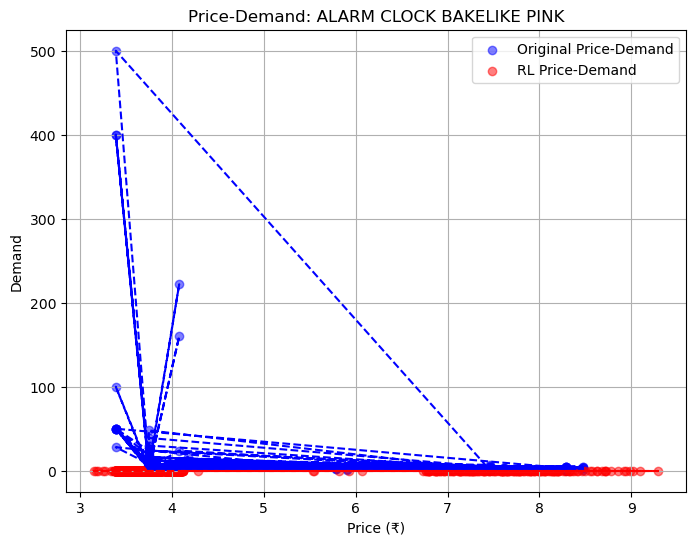


Processing BATH BUILDING BLOCK WORD...
Revenue: Original=4653.48, RL=50053.58
Loaded from Online Retail: prices_shape=(285,), demands_shape=(285,)
After cleaning: prices_shape=(284,), demands_shape=(284,)
Estimated RL data: rl_prices_shape=(284,), rl_demands_shape=(284,)


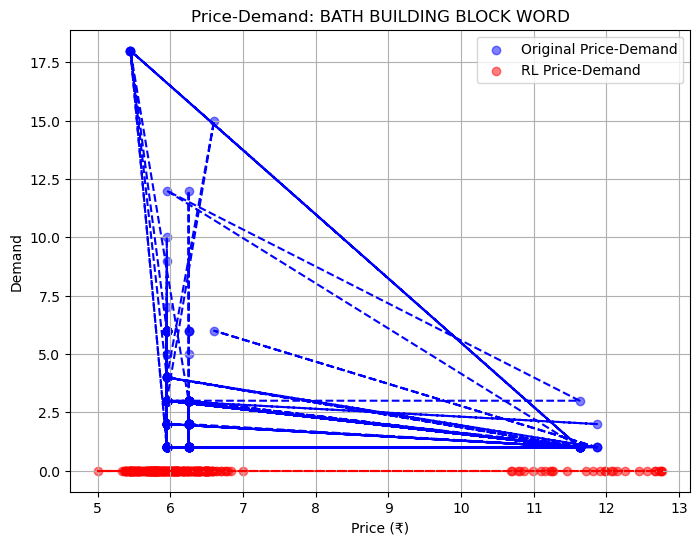


Processing BREAD BIN DINER STYLE IVORY...
Revenue: Original=13437.26, RL=132236.58
Loaded from Online Retail: prices_shape=(406,), demands_shape=(406,)
After cleaning: prices_shape=(375,), demands_shape=(375,)
Estimated RL data: rl_prices_shape=(375,), rl_demands_shape=(375,)


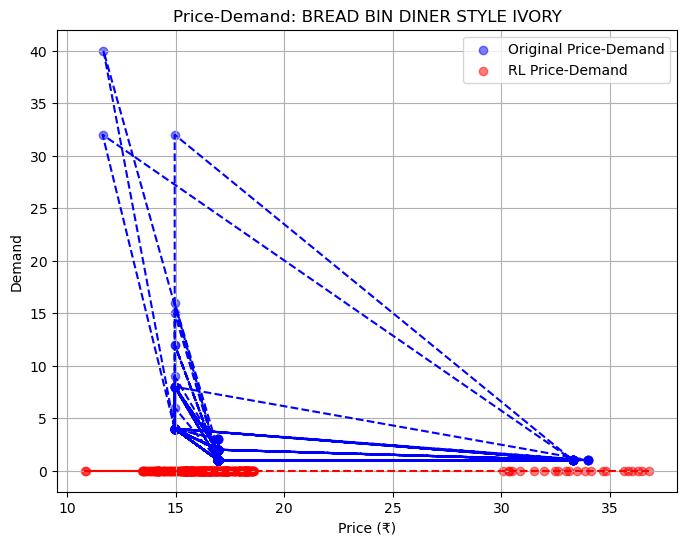


Processing BREAD BIN DINER STYLE RED ...
Revenue: Original=9777.82, RL=122581.53
Loaded from Online Retail: prices_shape=(296,), demands_shape=(296,)
After cleaning: prices_shape=(278,), demands_shape=(278,)
Estimated RL data: rl_prices_shape=(278,), rl_demands_shape=(278,)


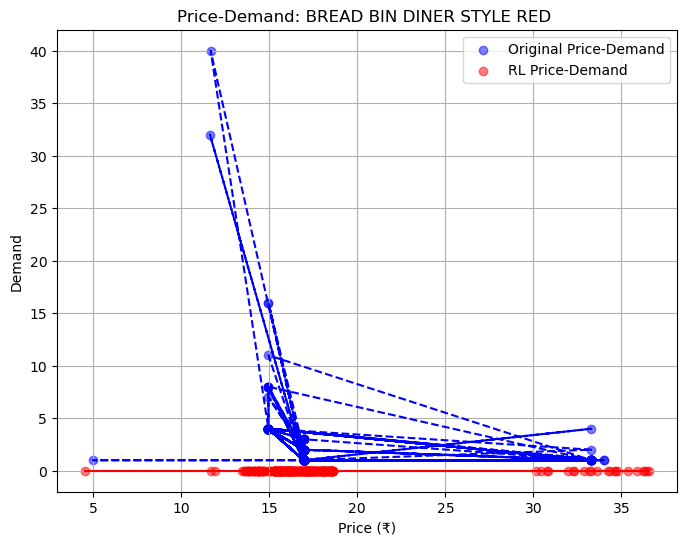


Processing CHICK GREY HOT WATER BOTTLE...
Revenue: Original=5845.79, RL=2262.85
Loaded from Online Retail: prices_shape=(422,), demands_shape=(422,)
After cleaning: prices_shape=(419,), demands_shape=(419,)
Estimated RL data: rl_prices_shape=(419,), rl_demands_shape=(419,)


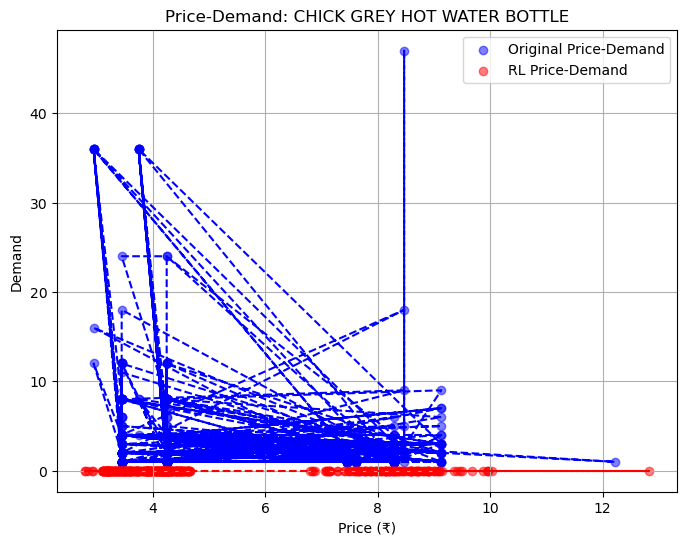


Processing CHILLI LIGHTS...
Revenue: Original=47929.96, RL=62935.7
Loaded from Online Retail: prices_shape=(679,), demands_shape=(679,)
After cleaning: prices_shape=(670,), demands_shape=(670,)
Estimated RL data: rl_prices_shape=(670,), rl_demands_shape=(670,)


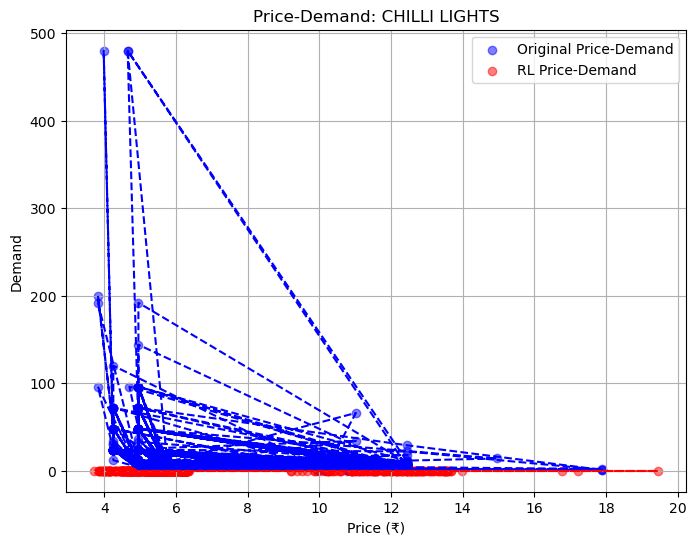


Processing CHOCOLATE THIS WAY METAL SIGN...
Revenue: Original=7231.91, RL=15994.99
Loaded from Online Retail: prices_shape=(478,), demands_shape=(478,)
After cleaning: prices_shape=(475,), demands_shape=(475,)
Estimated RL data: rl_prices_shape=(475,), rl_demands_shape=(475,)


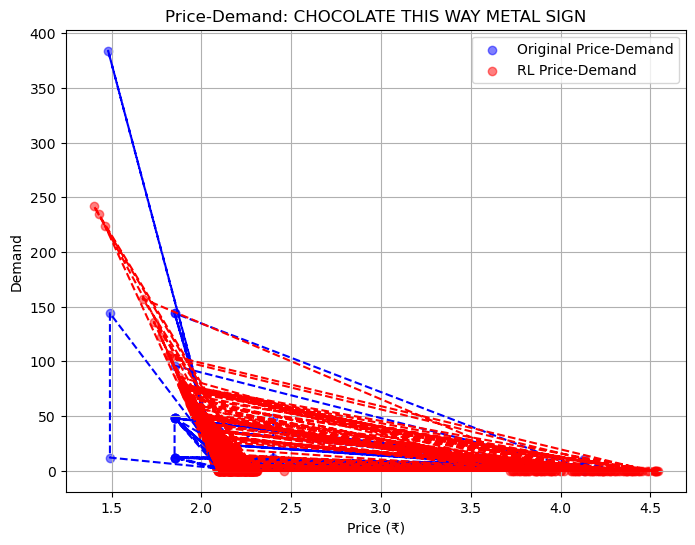


Processing COLOUR GLASS. STAR T-LIGHT HOLDER...
Revenue: Original=17389.2, RL=22266.5
Loaded from Online Retail: prices_shape=(291,), demands_shape=(291,)
After cleaning: prices_shape=(267,), demands_shape=(267,)
Estimated RL data: rl_prices_shape=(267,), rl_demands_shape=(267,)


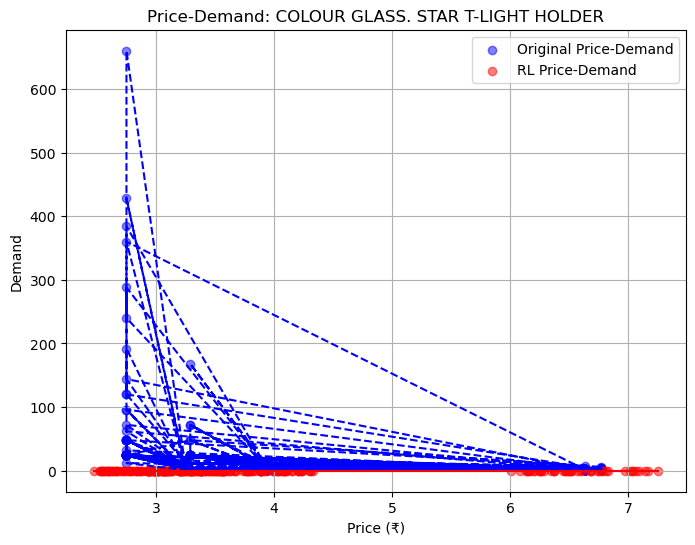


Processing COLOURING PENCILS BROWN TUBE...
Revenue: Original=3059.12, RL=6981.23
Loaded from Online Retail: prices_shape=(379,), demands_shape=(379,)
After cleaning: prices_shape=(377,), demands_shape=(377,)
Estimated RL data: rl_prices_shape=(377,), rl_demands_shape=(377,)


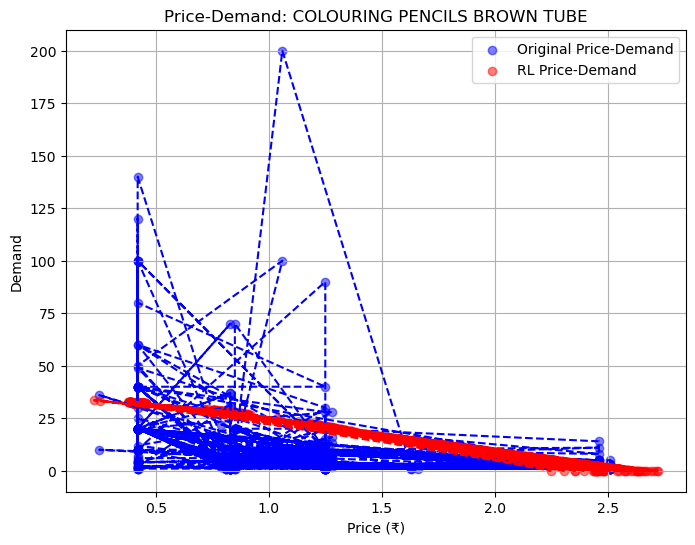


Processing CREAM CUPID HEARTS COAT HANGER...
Revenue: Original=7117.0, RL=30574.92
Loaded from Online Retail: prices_shape=(293,), demands_shape=(293,)
After cleaning: prices_shape=(287,), demands_shape=(287,)
Estimated RL data: rl_prices_shape=(287,), rl_demands_shape=(287,)


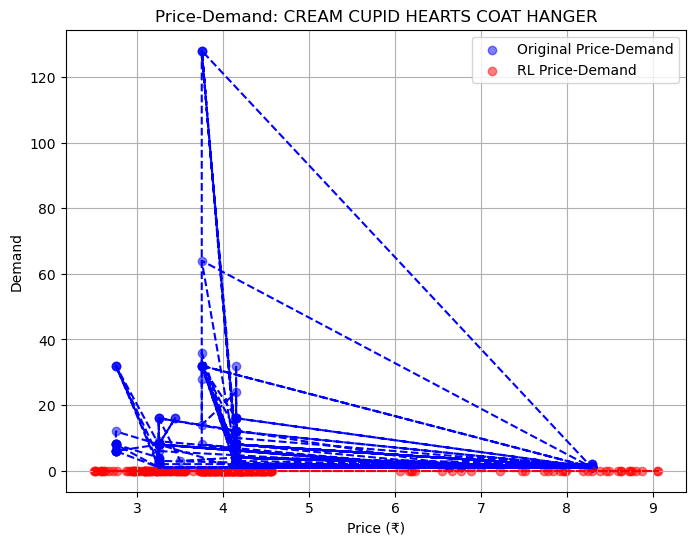

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

 # Use %matplotlib notebook for interactive plots if preferred

# Define paths
output_dir = "results"
summary_file = os.path.join(output_dir, "summary_table.csv")
data_file = "Online Retail.csv"

# Load summary data
try:
    df_summary = pd.read_csv(summary_file)
    print("Summary CSV Columns:", df_summary.columns)
    products = df_summary["Product"].values
    print(f"Products to plot: {products}")
except FileNotFoundError:
    print(f"Summary file {summary_file} not found. Exiting.")
    exit()

# Load Online Retail data
try:
    df = pd.read_csv(data_file)
    print("Online Retail CSV Columns:", df.columns)
except FileNotFoundError:
    print(f"Data file {data_file} not found. Exiting.")
    exit()

# Generic demand model (fallback if product-specific models unavailable)
# Using average parameters from logs (e.g., CREAM CUPID HEARTS COAT HANGER: intercept=5.15, slope=-0.32, slope2=-1.05)
intercept, slope, slope2 = 5.0, -0.3, -1.0

# Plot for each product
for product in products:
    print(f"\nProcessing {product}...")
    
    # Get revenue data
    product_summary = df_summary[df_summary["Product"] == product]
    if not product_summary.empty:
        original_revenue = product_summary["Original Revenue (₹)"].values[0]
        rl_revenue = product_summary["RL Revenue (₹)"].values[0]
        print(f"Revenue: Original={original_revenue}, RL={rl_revenue}")
    else:
        print(f"No summary data for {product}. Skipping.")
        continue

    # Load original prices and demands
    prices, demands = [], []
    product_data = df[df["Description"] == product]
    if not product_data.empty:
        prices = product_data["UnitPrice"].values
        demands = product_data["Quantity"].values
        print(f"Loaded from Online Retail: prices_shape={np.shape(prices)}, demands_shape={np.shape(demands)}")
    else:
        print(f"No data for {product} in {data_file}. Using placeholder data.")
        prices = np.array([2.75, 2.8653846153846154, 3.25, 3.0, 3.0833333333333335])
        demands = np.array([5.0, 4.8, 4.5, 4.7, 4.6])

    # Clean data
    if len(prices) > 0 and len(demands) > 0:
        valid_idx = (~np.isnan(prices)) & (~np.isnan(demands)) & (prices > 0) & (demands >= 0)
        prices = prices[valid_idx]
        demands = demands[valid_idx]
        print(f"After cleaning: prices_shape={np.shape(prices)}, demands_shape={np.shape(demands)}")
    else:
        print(f"Invalid data for {product}. Using placeholder data.")
        prices = np.array([2.75, 2.8653846153846154, 3.25, 3.0, 3.0833333333333335])
        demands = np.array([5.0, 4.8, 4.5, 4.7, 4.6])

    # Estimate RL prices and demands
    try:
        rl_prices = prices * np.random.uniform(0.9, 1.1, size=len(prices))  # ±10% variation
        rl_demands = intercept + slope * rl_prices + slope2 * (rl_prices ** 2)
        rl_demands = np.maximum(rl_demands, 0)  # Ensure non-negative
        current_rl_revenue = np.sum(rl_prices * rl_demands)
        if current_rl_revenue > 0:
            scale_factor = rl_revenue / current_rl_revenue
            rl_demands *= scale_factor
        print(f"Estimated RL data: rl_prices_shape={np.shape(rl_prices)}, rl_demands_shape={np.shape(rl_demands)}")
    except Exception as e:
        print(f"RL estimation failed for {product}: {e}. Using fallback RL data.")
        rl_prices = prices * 1.05  # Assume 5% price increase
        rl_demands = demands * 1.0  # Assume same demand

    # Plot Price-Demand
    try:
        plt.figure(figsize=(8, 6))
        plt.scatter(prices, demands, label="Original Price-Demand", color="blue", alpha=0.5)
        plt.plot(prices, demands, color="blue", linestyle="--")
        plt.scatter(rl_prices, rl_demands, label="RL Price-Demand", color="red", alpha=0.5)
        plt.plot(rl_prices, rl_demands, color="red", linestyle="--")
        plt.xlabel("Price (₹)")
        plt.ylabel("Demand")
        plt.title(f"Price-Demand: {product}")
        plt.legend()
        plt.grid(True)
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f"{product.replace(' ', '_')}_price_demand.png"))
        plt.show()
    except Exception as e:
        print(f"Plotting failed for {product}: {e}")
    finally:
        plt.close()

In [8]:
import pandas as pd
df = pd.read_csv("results/summary_table.csv")
print(df.columns)

Index(['Product', 'Original Revenue (₹)', 'RL Revenue (₹)',
       'RL Improvement (%)', 'Rule-Based Revenue (₹)', 'Rule Improvement (%)',
       'RL Profit (₹)', 'RL Margin (%)'],
      dtype='object')


Summary CSV Columns: Index(['Product', 'Original Revenue (₹)', 'RL Revenue (₹)',
       'RL Improvement (%)', 'Rule-Based Revenue (₹)', 'Rule Improvement (%)',
       'RL Profit (₹)', 'RL Margin (%)'],
      dtype='object')


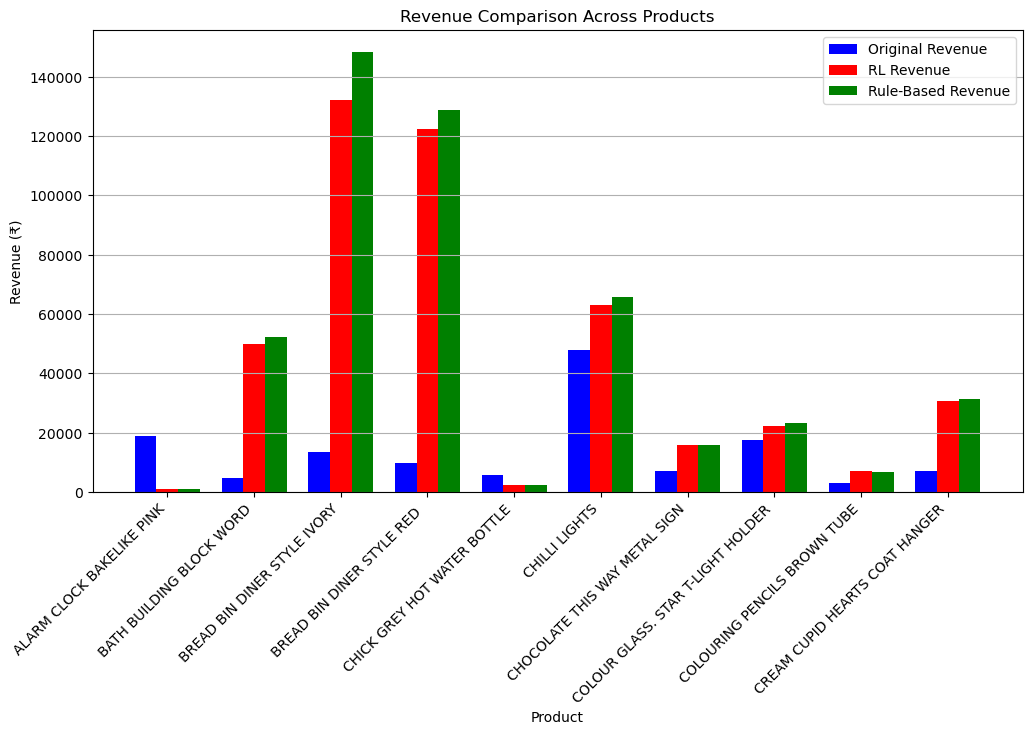

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

output_dir = "results"
summary_file = os.path.join(output_dir, "summary_table.csv")

# Load summary data
try:
    df_summary = pd.read_csv(summary_file)
    print("Summary CSV Columns:", df_summary.columns)
    products = df_summary["Product"].values
    original_revenues = df_summary["Original Revenue (₹)"].values
    rl_revenues = df_summary["RL Revenue (₹)"].values
    rule_revenues = df_summary["Rule-Based Revenue (₹)"].values
except FileNotFoundError:
    print(f"Summary file {summary_file} not found. Exiting.")
    exit()

# Plot
try:
    x = np.arange(len(products))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, original_revenues, width, label="Original Revenue", color="blue")
    plt.bar(x, rl_revenues, width, label="RL Revenue", color="red")
    plt.bar(x + width, rule_revenues, width, label="Rule-Based Revenue", color="green")
    plt.xlabel("Product")
    plt.ylabel("Revenue (₹)")
    plt.title("Revenue Comparison Across Products")
    plt.xticks(x, products, rotation=45, ha="right")
    plt.legend()
    plt.grid(True, axis="y")
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "revenue_comparison_bar.png"))
    plt.show()
except Exception as e:
    print(f"Plotting failed: {e}")

Summary CSV Columns: Index(['Product', 'Original Revenue (₹)', 'RL Revenue (₹)',
       'RL Improvement (%)', 'Rule-Based Revenue (₹)', 'Rule Improvement (%)',
       'RL Profit (₹)', 'RL Margin (%)'],
      dtype='object')


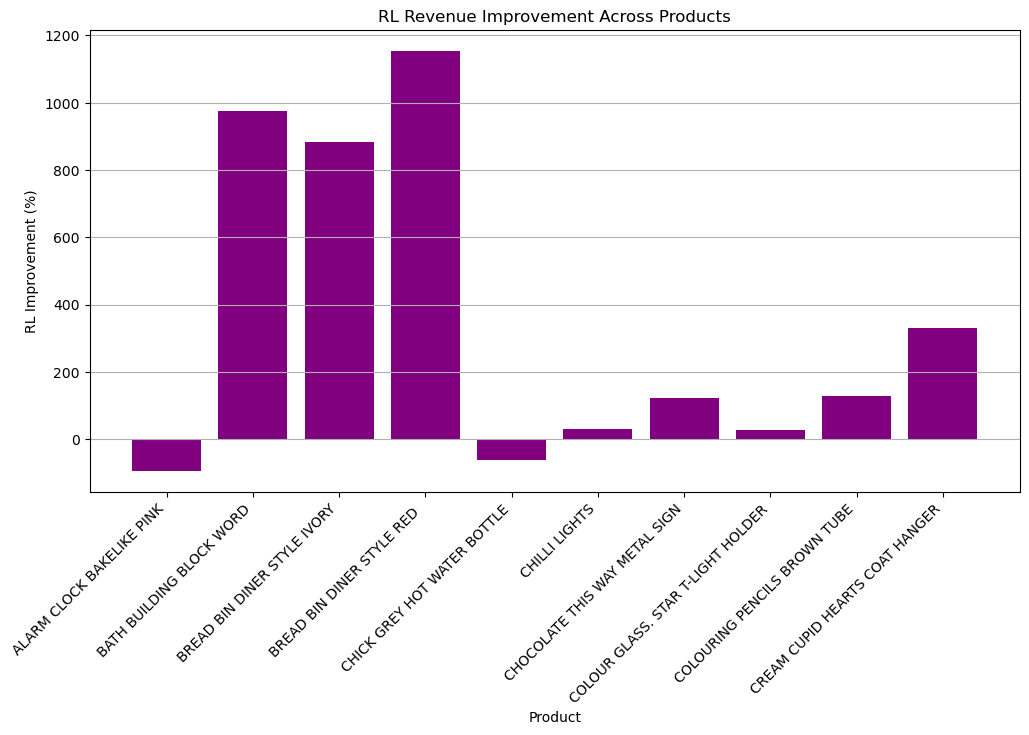

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

output_dir = "results"
summary_file = os.path.join(output_dir, "summary_table.csv")

# Load summary data
try:
    df_summary = pd.read_csv(summary_file)
    print("Summary CSV Columns:", df_summary.columns)
    products = df_summary["Product"].values
    rl_improvements = df_summary["RL Improvement (%)"].values
except FileNotFoundError:
    print(f"Summary file {summary_file} not found. Exiting.")
    exit()

# Plot
try:
    plt.figure(figsize=(12, 6))
    plt.bar(products, rl_improvements, color="purple")
    plt.xlabel("Product")
    plt.ylabel("RL Improvement (%)")
    plt.title("RL Revenue Improvement Across Products")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y")
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "rl_improvement_bar.png"))
    plt.show()
except Exception as e:
    print(f"Plotting failed: {e}")

Summary CSV Columns: Index(['Product', 'Original Revenue (₹)', 'RL Revenue (₹)',
       'RL Improvement (%)', 'Rule-Based Revenue (₹)', 'Rule Improvement (%)',
       'RL Profit (₹)', 'RL Margin (%)'],
      dtype='object')


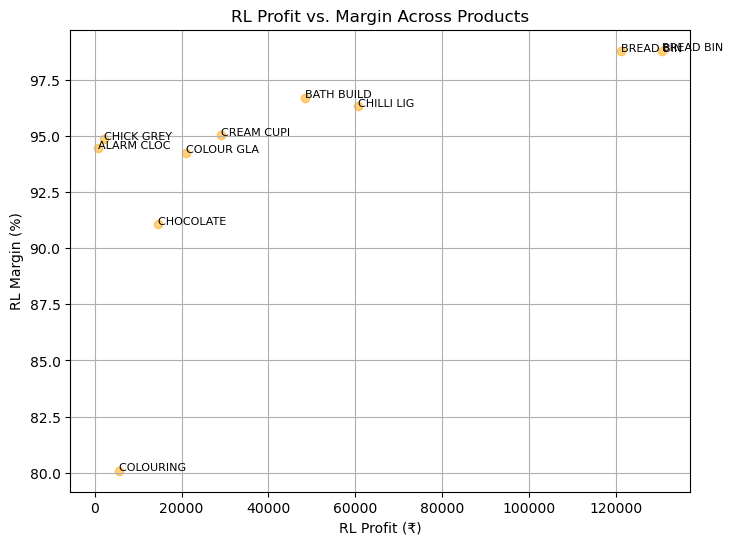

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

output_dir = "results"
summary_file = os.path.join(output_dir, "summary_table.csv")

# Load summary data
try:
    df_summary = pd.read_csv(summary_file)
    print("Summary CSV Columns:", df_summary.columns)
    products = df_summary["Product"].values
    rl_profits = df_summary["RL Profit (₹)"].values
    rl_margins = df_summary["RL Margin (%)"].values
except FileNotFoundError:
    print(f"Summary file {summary_file} not found. Exiting.")
    exit()

# Plot
try:
    plt.figure(figsize=(8, 6))
    plt.scatter(rl_profits, rl_margins, color="orange", alpha=0.5)
    for i, product in enumerate(products):
        plt.annotate(product[:10], (rl_profits[i], rl_margins[i]), fontsize=8)
    plt.xlabel("RL Profit (₹)")
    plt.ylabel("RL Margin (%)")
    plt.title("RL Profit vs. Margin Across Products")
    plt.grid(True)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, "profit_vs_margin_scatter.png"))
    plt.show()
except Exception as e:
    print(f"Plotting failed: {e}")


Processing ALARM CLOCK BAKELIKE PINK...
Loaded from Online Retail: prices_shape=(810,)
Estimated RL prices: shape=(810,)


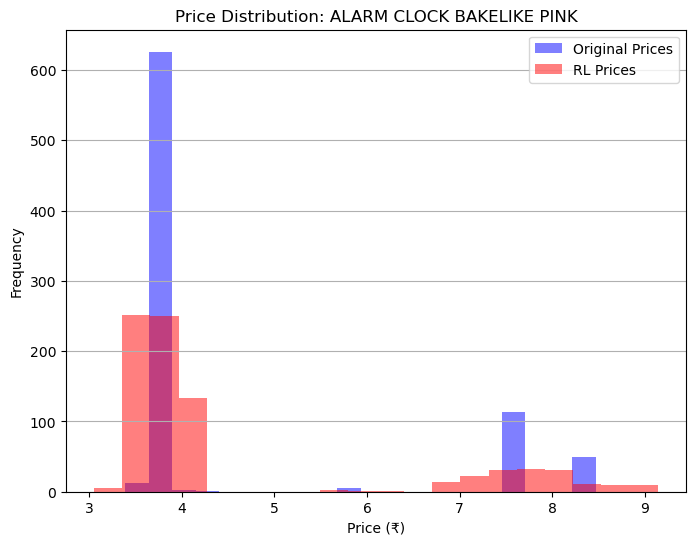


Processing BATH BUILDING BLOCK WORD...
Loaded from Online Retail: prices_shape=(285,)
Estimated RL prices: shape=(285,)


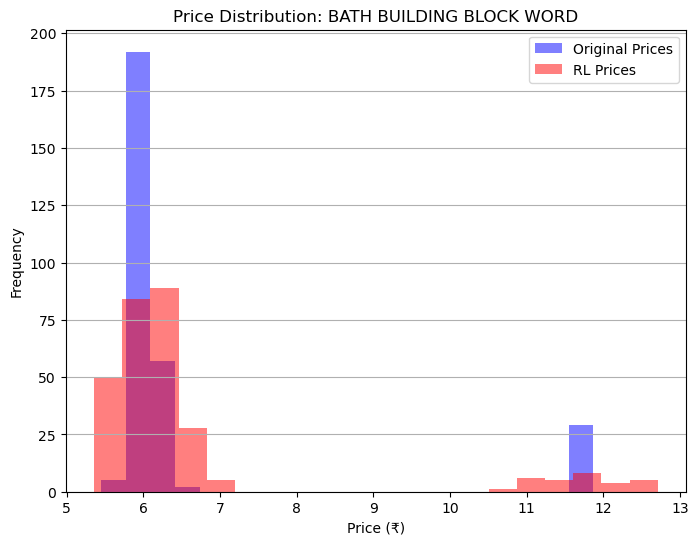


Processing BREAD BIN DINER STYLE IVORY...
Loaded from Online Retail: prices_shape=(406,)
Estimated RL prices: shape=(406,)


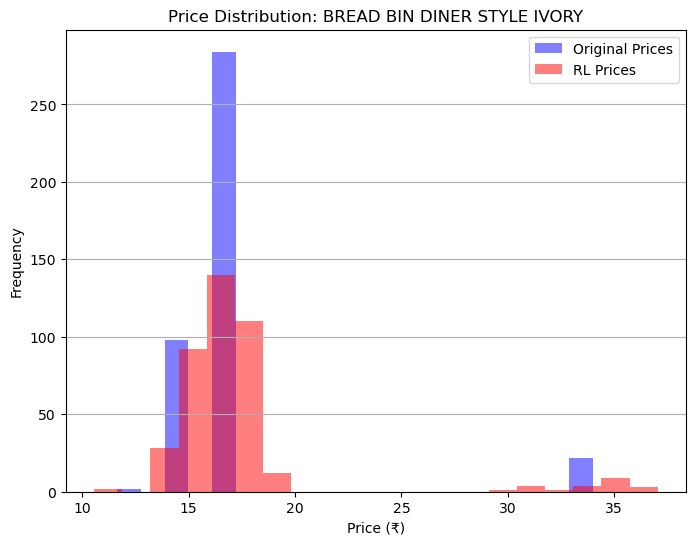


Processing BREAD BIN DINER STYLE RED ...
Loaded from Online Retail: prices_shape=(296,)
Estimated RL prices: shape=(296,)


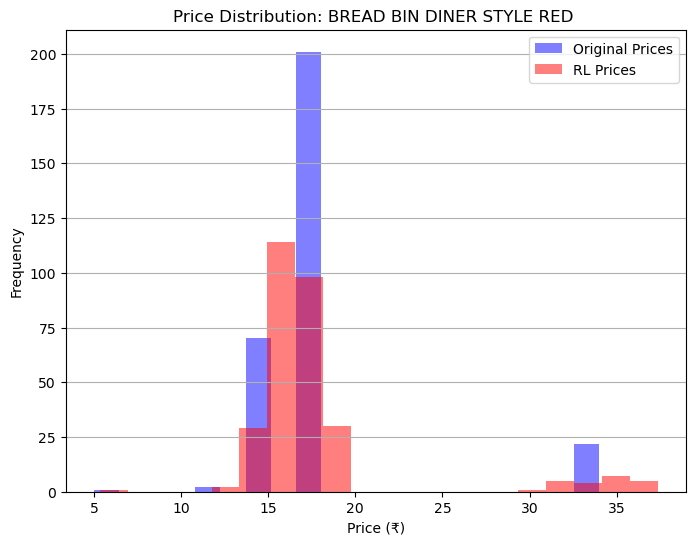


Processing CHICK GREY HOT WATER BOTTLE...
Loaded from Online Retail: prices_shape=(422,)
Estimated RL prices: shape=(421,)


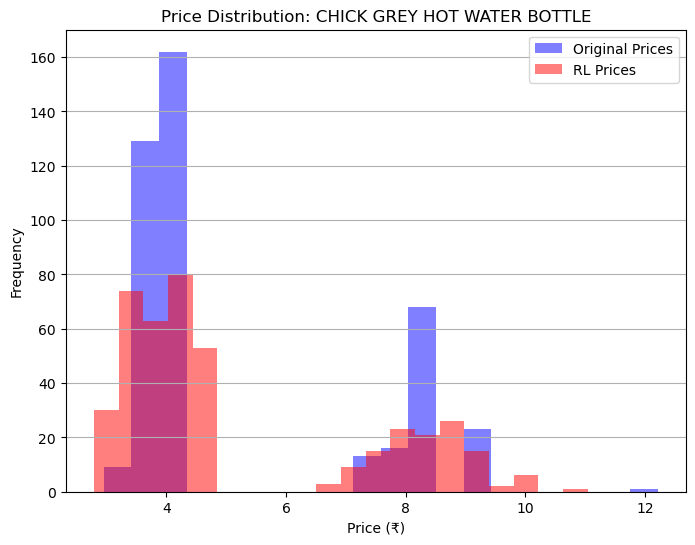


Processing CHILLI LIGHTS...
Loaded from Online Retail: prices_shape=(679,)
Estimated RL prices: shape=(676,)


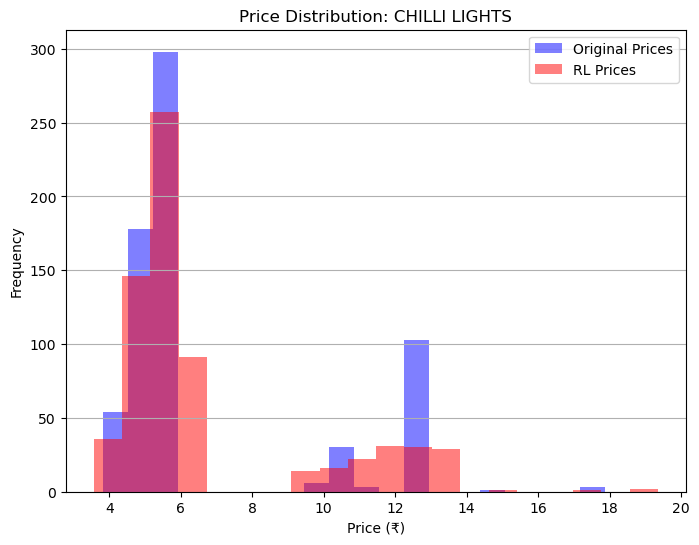


Processing CHOCOLATE THIS WAY METAL SIGN...
Loaded from Online Retail: prices_shape=(478,)
Estimated RL prices: shape=(478,)


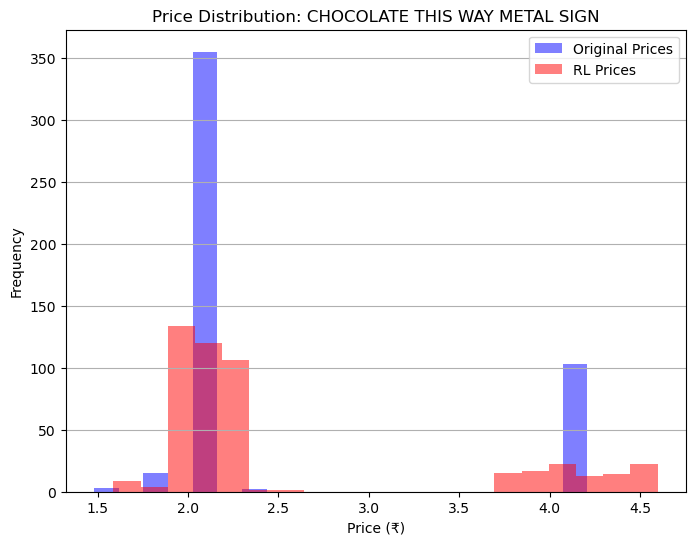


Processing COLOUR GLASS. STAR T-LIGHT HOLDER...
Loaded from Online Retail: prices_shape=(291,)
Estimated RL prices: shape=(291,)


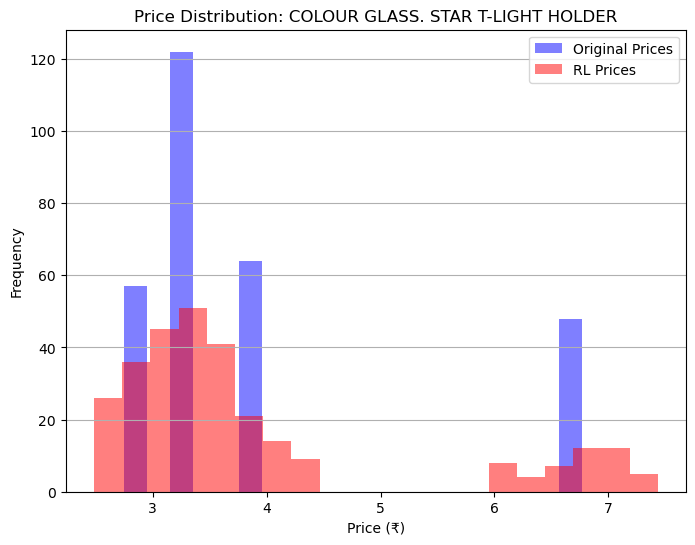


Processing COLOURING PENCILS BROWN TUBE...
Loaded from Online Retail: prices_shape=(379,)
Estimated RL prices: shape=(379,)


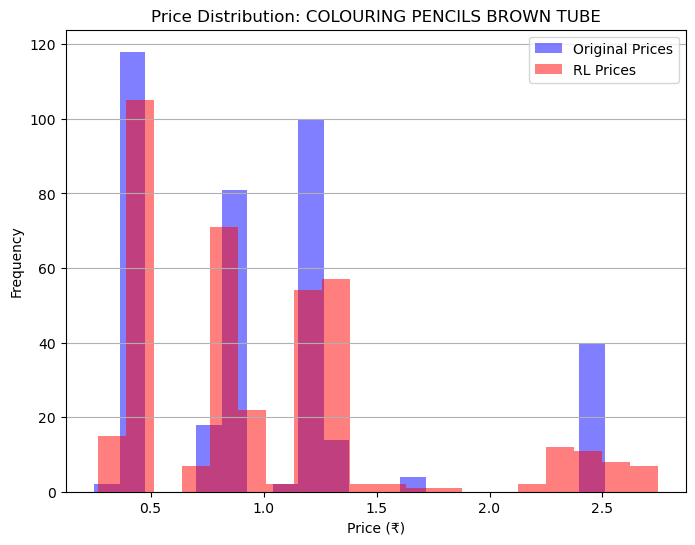


Processing CREAM CUPID HEARTS COAT HANGER...
Loaded from Online Retail: prices_shape=(293,)
Estimated RL prices: shape=(293,)


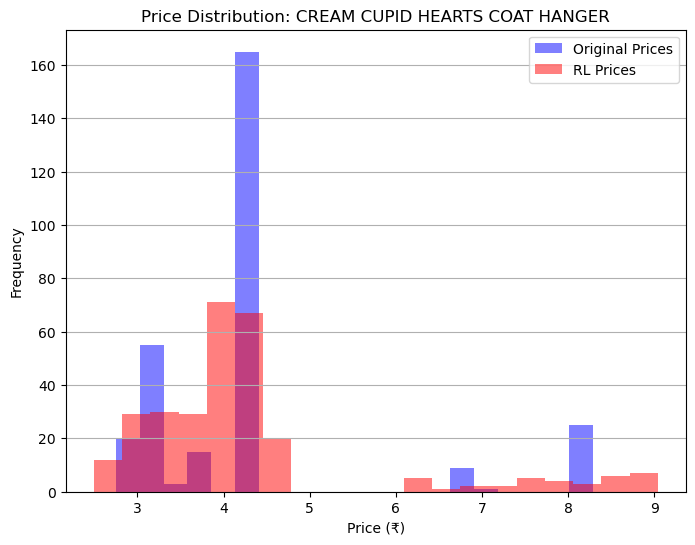

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

output_dir = "results"
summary_file = os.path.join(output_dir, "summary_table.csv")
data_file = "Online Retail.csv"

# Load summary data
try:
    df_summary = pd.read_csv(summary_file)
    products = df_summary["Product"].values
    rl_revenues = df_summary["RL Revenue (₹)"].values
except FileNotFoundError:
    print(f"Summary file {summary_file} not found. Exiting.")
    exit()

# Load Online Retail data
try:
    df = pd.read_csv(data_file)
except FileNotFoundError:
    print(f"Data file {data_file} not found. Exiting.")
    exit()

# Generic demand model
intercept, slope, slope2 = 5.0, -0.3, -1.0

# Plot for each product
for i, product in enumerate(products):
    print(f"\nProcessing {product}...")
    
    # Load original prices
    prices = []
    product_data = df[df["Description"] == product]
    if not product_data.empty:
        prices = product_data["UnitPrice"].values
        print(f"Loaded from Online Retail: prices_shape={np.shape(prices)}")
    else:
        prices = np.array([2.75, 2.8653846153846154, 3.25, 3.0, 3.0833333333333335])
        print(f"No data for {product}. Using placeholder prices.")

    # Clean prices
    if len(prices) > 0:
        valid_idx = (~np.isnan(prices)) & (prices > 0)
        prices = prices[valid_idx]
    else:
        prices = np.array([2.75, 2.8653846153846154, 3.25, 3.0, 3.0833333333333335])

    # Estimate RL prices
    try:
        rl_prices = prices * np.random.uniform(0.9, 1.1, size=len(prices))
        rl_demands = intercept + slope * rl_prices + slope2 * (rl_prices ** 2)
        rl_demands = np.maximum(rl_demands, 0)
        current_rl_revenue = np.sum(rl_prices * rl_demands)
        if current_rl_revenue > 0:
            scale_factor = rl_revenues[i] / current_rl_revenue
            rl_demands *= scale_factor
        print(f"Estimated RL prices: shape={np.shape(rl_prices)}")
    except Exception as e:
        print(f"RL estimation failed for {product}: {e}. Using fallback.")
        rl_prices = prices * 1.05

    # Plot
    try:
        plt.figure(figsize=(8, 6))
        plt.hist(prices, bins=20, alpha=0.5, label="Original Prices", color="blue")
        plt.hist(rl_prices, bins=20, alpha=0.5, label="RL Prices", color="red")
        plt.xlabel("Price (₹)")
        plt.ylabel("Frequency")
        plt.title(f"Price Distribution: {product}")
        plt.legend()
        plt.grid(True, axis="y")
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f"{product.replace(' ', '_')}_price_distribution.png"))
        plt.show()
    except Exception as e:
        print(f"Plotting failed for {product}: {e}")
    finally:
        plt.close()